**1. Examine the Training Data Distribution
Check Class Counts:**
Look at the distribution of your severity labels in the training set. If the high-severity classes (e.g., class 2 or 3) are very rare compared to low-severity cases, the model may be strongly biased toward predicting class 0.


**2. Rebalance the Training Data**
If high-severity samples are underrepresented, consider rebalancing the data. Some options are:

**3. Vary Multiple Features Simultaneously**
Your current parameter sweep varied only "Total Fwd Packets" and "Fwd Packet Length Max" individually. Consider a grid search that varies multiple key features together, such as:

Total Fwd Packets
Total Length of Fwd Packets
Fwd Packet Length Max
Flow IAT Min
This multi-dimensional grid search might reveal interactions that lead to a higher predicted severity.

**4. Examine Predicted Probabilities**
Use your /debug endpoint (or modify your script to print probabilities) to see if the model’s probability for the high-severity class increases at all when you vary inputs. If the probability for class 2 ("High") stays near 0, even with extreme values, then the model is not sensitive enough due to its training bias.

**5. Feature Engineering and Model Tuning**

**Create New Features:**

Consider deriving additional features or combining existing ones. For instance, ratios or differences between forward and backward traffic might provide more insight.

**Hyperparameter Tuning:**

Try tuning model parameters using techniques like GridSearchCV or RandomizedSearchCV to see if the model’s decision boundaries can be adjusted.

**Alternative Models:**

If LightGBM remains insensitive, you might experiment with other algorithms like XGBoost or even deep learning models that might capture non-linear relationships more effectively.





In [ ]:
import os
# Disable debugger file validation to reduce overhead in Colab
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# If using Google Drive, uncomment these lines:
from google.colab import drive
drive.mount('/content/drive')
# And set checkpoint paths accordingly

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 1. Define file paths
file_paths = [
    r"/content/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
    r"/content/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    r"/content/Friday-WorkingHours-Morning.pcap_ISCX.csv",
    r"/content/Monday-WorkingHours.pcap_ISCX.csv",
    r"/content/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
    r"/content/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
    r"/content/Tuesday-WorkingHours.pcap_ISCX.csv",
    r"/content/Wednesday-workingHours.pcap_ISCX.csv"
]

In [ ]:
# 2. Define attack type mapping based on file names
attack_type_mapping = {
    "DDos": "DDos",
    "PortScan": "PortScan",
    "Infilteration": "Infilteration",
    "WebAttacks": "WebAttacks",
    "Morning": "Benign",
    "Afternoon": "Benign",
    "Monday": "Benign",
    "Tuesday": "Benign",
    "Wednesday": "Benign",
    "Thursday": "Benign",
    "Friday": "Benign"
}

In [ ]:
# 3. Load and combine data
data_frames = []
for file_path in file_paths:
    df = pd.read_csv(file_path)
    # Assign attack type based on file name
    for key, value in attack_type_mapping.items():
        if key in file_path:
            df['attack_type'] = value
            break
    data_frames.append(df)
combined_df = pd.concat(data_frames, ignore_index=True)

In [ ]:

# 4. Define severity mapping
severity_mapping = {
    "Benign": 0,
    "PortScan": 1,
    "Probe": 1,
    "DDos": 2,
    "Infilteration": 3,
    "WebAttacks": 3
}
combined_df['severity'] = combined_df['attack_type'].map(severity_mapping)

In [ ]:
# 5. Data Cleaning
combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)
numeric_cols = combined_df.select_dtypes(include=[np.number]).columns
combined_df[numeric_cols] = combined_df[numeric_cols].fillna(combined_df[numeric_cols].mean())

Columns in combined_df:
[' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK 

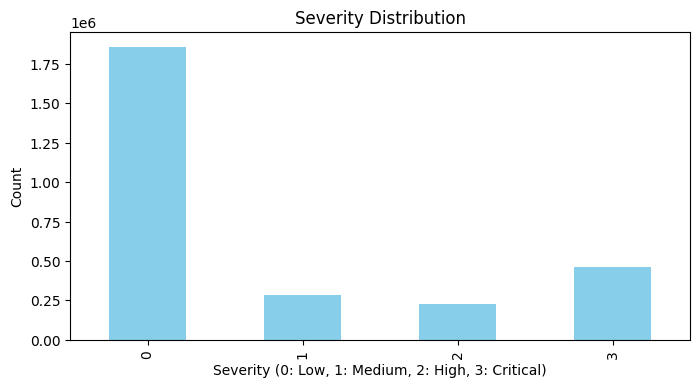

In [ ]:
# 6. Examine Columns and Distribution
print("Columns in combined_df:")
print(combined_df.columns.tolist())

# Count the distribution of severity labels
severity_counts = combined_df['severity'].value_counts()
print("Severity distribution:")
print(severity_counts)

# Plot a bar chart of severity distribution
plt.figure(figsize=(8, 4))
severity_counts.sort_index().plot(kind='bar', color='skyblue')
plt.title("Severity Distribution")
plt.xlabel("Severity (0: Low, 1: Medium, 2: High, 3: Critical)")
plt.ylabel("Count")
plt.show()

In [ ]:
# 7. Focus on High Severity: Get descriptive stats for key features in high-severity cases
high_severity = combined_df[combined_df['severity'] >= 2]
print("Descriptive statistics for key features in high severity cases:")
key_features = [' Total Fwd Packets', 'Total Length of Fwd Packets',
                ' Fwd Packet Length Max', ' Flow IAT Min',
                ' act_data_pkt_fwd', ' min_seg_size_forward']
print(high_severity[key_features].describe())

Descriptive statistics for key features in high severity cases:
        Total Fwd Packets  Total Length of Fwd Packets  \
count       684713.000000                 6.847130e+05   
mean             7.996236                 6.869765e+02   
std            562.392706                 1.744727e+04   
min              1.000000                 0.000000e+00   
25%              2.000000                 1.200000e+01   
50%              2.000000                 4.800000e+01   
75%              4.000000                 9.200000e+01   
max         200755.000000                 1.290000e+07   

        Fwd Packet Length Max   Flow IAT Min   act_data_pkt_fwd  \
count           684713.000000   6.847130e+05      684713.000000   
mean               278.663168   7.630637e+04           5.507061   
std               1145.411245   1.926127e+06         538.695871   
min                  0.000000  -1.200000e+01           0.000000   
25%                  6.000000   3.000000e+00           1.000000   
50%        

In [ ]:
# 8. Prepare Features and Target for Modeling
# Drop non-predictor columns. Here, drop ' Label', 'attack_type', and 'severity'
X = combined_df.drop(columns=[' Label', 'attack_type', 'severity'])
y = combined_df['severity']
print("Number of predictor features:", X.shape[1])  # Should be 78

# Save the original feature column names for inference later
original_feature_columns = X.columns.tolist()
joblib.dump(original_feature_columns, 'original_feature_columns.pkl')
print("Original feature columns saved.")

Number of predictor features: 78
Original feature columns saved.


In [ ]:
# 9. Identify categorical and numerical features for preprocessing
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=[np.number]).columns

In [ ]:
# 10. Build Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [ ]:
# # 11. Create a Pipeline with LightGBM Classifier
# lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1)
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', lgb_model)
# ])


# 11. Compute Class Weights to Handle Imbalance
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))
print("Class weights:", class_weights)

Class weights: {0: 0.38056562213810446, 1: 2.470391877598467, 2: 3.13489003078695, 3: 1.541906516358439}


In [ ]:
# 12. Create a Pipeline with LightGBM Classifier Using Class Weights
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight=class_weights)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb_model)
])

In [ ]:
# 12. Split the Data into Training and Validation Sets
# 13. Split the Data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# # 13. Apply SMOTE to Rebalance Training Data
# smote = SMOTE(random_state=42)
# X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
# print("Training distribution after SMOTE:")
# print(pd.Series(y_train_res).value_counts())

# # Save a checkpoint of the resampled training data
# X_train_res.to_csv("X_train_res_checkpoint.csv", index=False)
# pd.Series(y_train_res).to_csv("y_train_res_checkpoint.csv", index=False)
# print("Resampled training data checkpoint saved.")

In [ ]:
# # 14. Train the Model on the Resampled Data
# pipeline.fit(X_train_res, y_train_res)

# 14. Train the Model on the Original (Rebalanced via class weights) Data
pipeline.fit(X_train, y_train)

In [ ]:
# 15. Evaluate the Model
y_pred = pipeline.predict(X_val)
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

In [ ]:
# 16. Save the Trained Pipeline and Scaler
joblib.dump(pipeline, 'model_cicids_lightgbm.pkl')
joblib.dump(preprocessor.named_transformers_['num'], 'scaler_cicids.pkl')
print("Pipeline and scaler saved.")

Columns in combined_df:
[' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK 

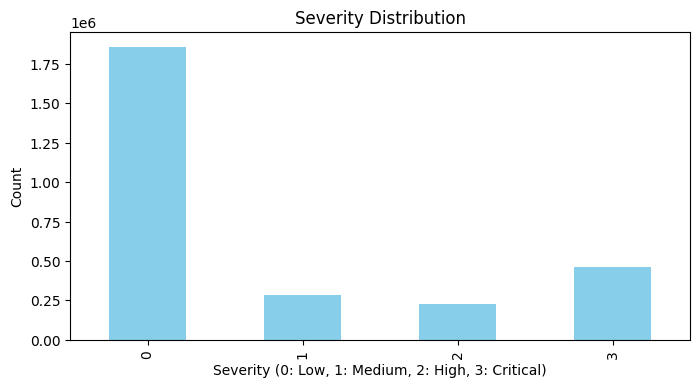

Descriptive statistics for high-severity key features:
        Total Fwd Packets  Total Length of Fwd Packets  \
count       684713.000000                 6.847130e+05   
mean             7.996236                 6.869765e+02   
std            562.392706                 1.744727e+04   
min              1.000000                 0.000000e+00   
25%              2.000000                 1.200000e+01   
50%              2.000000                 4.800000e+01   
75%              4.000000                 9.200000e+01   
max         200755.000000                 1.290000e+07   

        Fwd Packet Length Max   Flow IAT Min   act_data_pkt_fwd  \
count           684713.000000   6.847130e+05      684713.000000   
mean               278.663168   7.630637e+04           5.507061   
std               1145.411245   1.926127e+06         538.695871   
min                  0.000000  -1.200000e+01           0.000000   
25%                  6.000000   3.000000e+00           1.000000   
50%                 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.225288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14597
[LightGBM] [Info] Number of data points in the train set: 226459, number of used features: 70
[LightGBM] [Info] Start training from score -1.384360
[LightGBM] [Info] Start training from score -1.391803
[LightGBM] [Info] Start training from score -1.377794
[LightGBM] [Info] Start training from score -1.391287


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.59      0.71    372690
           1       0.84      0.60      0.70     57321
           2       0.90      0.75      0.82     44869
           3       0.28      0.73      0.41     91269

    accuracy                           0.63    566149
   macro avg       0.72      0.67      0.66    566149
weighted avg       0.77      0.63      0.67    566149

Confusion Matrix:
[[221391   4446   2341 144512]
 [  7912  34124    194  15091]
 [  3431    393  33848   7197]
 [ 21716   1861   1385  66307]]
Pipeline and scaler saved as checkpoints.


In [ ]:
import os
# Disable debugger file validation to reduce overhead in Colab
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from sklearn.utils.class_weight import compute_class_weight

# If using Google Drive, uncomment these lines:
# from google.colab import drive
# drive.mount('/content/drive')
# And set checkpoint paths accordingly

# 1. Define file paths (update paths as needed)
file_paths = [
    r"/content/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
    r"/content/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    r"/content/Friday-WorkingHours-Morning.pcap_ISCX.csv",
    r"/content/Monday-WorkingHours.pcap_ISCX.csv",
    r"/content/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
    r"/content/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
    r"/content/Tuesday-WorkingHours.pcap_ISCX.csv",
    r"/content/Wednesday-workingHours.pcap_ISCX.csv"
]

# 2. Define attack type mapping based on file names
attack_type_mapping = {
    "DDos": "DDos",
    "PortScan": "PortScan",
    "Infilteration": "Infilteration",
    "WebAttacks": "WebAttacks",
    "Morning": "Benign",
    "Afternoon": "Benign",
    "Monday": "Benign",
    "Tuesday": "Benign",
    "Wednesday": "Benign",
    "Thursday": "Benign",
    "Friday": "Benign"
}

# 3. Load and combine data
data_frames = []
for file_path in file_paths:
    df = pd.read_csv(file_path)
    # Assign attack type based on file name
    for key, value in attack_type_mapping.items():
        if key in file_path:
            df['attack_type'] = value
            break
    data_frames.append(df)
combined_df = pd.concat(data_frames, ignore_index=True)

# 4. Define severity mapping and apply it
severity_mapping = {
    "Benign": 0,
    "PortScan": 1,
    "Probe": 1,
    "DDos": 2,
    "Infilteration": 3,
    "WebAttacks": 3
}
combined_df['severity'] = combined_df['attack_type'].map(severity_mapping)

# 5. Data Cleaning: Replace inf and fill NaNs for numeric columns
combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)
numeric_cols = combined_df.select_dtypes(include=[np.number]).columns
combined_df[numeric_cols] = combined_df[numeric_cols].fillna(combined_df[numeric_cols].mean())

# 6. Examine columns and distribution
print("Columns in combined_df:")
print(combined_df.columns.tolist())

severity_counts = combined_df['severity'].value_counts()
print("Severity distribution:")
print(severity_counts)

plt.figure(figsize=(8, 4))
severity_counts.sort_index().plot(kind='bar', color='skyblue')
plt.title("Severity Distribution")
plt.xlabel("Severity (0: Low, 1: Medium, 2: High, 3: Critical)")
plt.ylabel("Count")
plt.show()

# 7. (Optional) Examine key feature distributions in high-severity cases
high_severity = combined_df[combined_df['severity'] >= 2]
key_features = [' Total Fwd Packets', 'Total Length of Fwd Packets',
                ' Fwd Packet Length Max', ' Flow IAT Min',
                ' act_data_pkt_fwd', ' min_seg_size_forward']
print("Descriptive statistics for high-severity key features:")
print(high_severity[key_features].describe())

# 8. Prepare Features and Target for Modeling
# Drop non-predictor columns: ' Label', 'attack_type', and 'severity'
X = combined_df.drop(columns=[' Label', 'attack_type', 'severity'])
y = combined_df['severity']
print("Number of predictor features:", X.shape[1])  # Expected: 78

# Save original feature column names for inference later
original_feature_columns = X.columns.tolist()
joblib.dump(original_feature_columns, 'original_feature_columns.pkl')
print("Original feature columns saved.")

# 9. Identify categorical and numerical features for preprocessing
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=[np.number]).columns

# 10. Build Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 11. Compute Class Weights to Address Imbalance
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))
print("Class weights:", class_weights)

# 12. Create a Pipeline with LightGBM Classifier Using Class Weights
# Reduce number of estimators to lower memory usage and set max_bin for efficiency
lgb_model = lgb.LGBMClassifier(
    n_estimators=50,  # Fewer trees
    max_bin=255,
    random_state=42,
    n_jobs=-1,
    class_weight=class_weights
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb_model)
])

# 13. Split the Data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 14. Downcast Training Data to Reduce Memory Usage
def downcast_df(df):
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = df[float_cols].astype('float32')
    int_cols = df.select_dtypes(include=['int64']).columns
    df[int_cols] = df[int_cols].astype('int32')
    return df

X_train_downcast = downcast_df(X_train.copy())

# 15. Use a Subset of the Training Data for Development (e.g., 10%)
sample_fraction = 0.1
X_train_subset = X_train_downcast.sample(frac=sample_fraction, random_state=42)
y_train_subset = y_train.loc[X_train_subset.index]
print("Training subset shape:", X_train_subset.shape)

# 16. Train the Model on the Subset
pipeline.fit(X_train_subset, y_train_subset)

# 17. Evaluate the Model on Validation Set
y_pred = pipeline.predict(X_val)
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# 18. Save the Trained Pipeline and Scaler as Checkpoints
joblib.dump(pipeline, 'model_cicids_lightgbm.pkl')
joblib.dump(preprocessor.named_transformers_['num'], 'scaler_cicids.pkl')
print("Pipeline and scaler saved as checkpoints.")


# Model Performance Analysis

Your training output shows that class 3 (Critical severity) has a very low precision (0.28) despite having a recall of 0.73, and overall accuracy is 63%. This indicates that while the model sometimes correctly recognizes high-severity cases, it still misclassifies many of them (e.g., class 3 is often confused with class 0). The imbalance in the data—even after using class weights—appears to be affecting the model's ability to distinguish all levels clearly.

# Next Steps to Address Model Bias and Test Severity Levels

## Parameter Sweep and Sensitivity Analysis
Conduct a multi-feature parameter sweep (grid search) to see how variations in key raw feature values affect the predicted probabilities for each severity level. For example:

- Vary "Total Fwd Packets" and "Fwd Packet Length Max" simultaneously.
- Record the predicted class probabilities using the debug endpoint or a dedicated script.
- Visualize these changes to understand which feature ranges push the model toward predicting higher severities.

This will help you determine which input ranges yield a more balanced spread of predictions.

## Further Hyperparameter Tuning

- **LightGBM Tuning**: Try adjusting parameters such as max_depth, learning_rate, and min_child_samples to help the model capture subtle differences between classes.
- **Ensemble Methods**: Consider ensembling models (e.g., combining LightGBM with XGBoost or RandomForest) to see if a combined prediction improves minority class performance.

## Enhanced Feature Engineering

- **Derive New Features**: Create features that capture relationships between existing ones (e.g., ratios, differences, or interactions between forward and backward traffic).
- **Transformations**: Explore log-transformations or other scaling techniques for highly skewed features to reduce the impact of extreme outliers.

## Improve Data Rebalancing
Although you used class weights—which is less memory intensive than oversampling—you might still experiment with using a combination of a smaller oversampling method (on a carefully chosen subset) along with class weights. For example, try oversampling just on the most underrepresented class or using a technique like ADASYN, which is a variant of SMOTE, to generate more diverse synthetic examples.

## API Testing with a Debug Endpoint

- Use your API's debug endpoint to get predicted probabilities for each class.
- Create a series of test payloads (either manually or via an automated script) that adjust key features across a range.
- Analyze how the probabilities change. If the probability for the high-severity class increases when you push certain features into their extreme ranges, that gives you insight into what inputs might trigger a "High" prediction.

*Obtaining the baseline raw feature vector directly from the training set (X_train)*

In [ ]:
# After you split the data, for example:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Get the first row of X_train as a baseline vector (it will have 78 features)
baseline = X_train.iloc[0].values  # This returns a NumPy array of 78 elements
print("Baseline raw feature vector:", baseline)


Baseline raw feature vector: [8.00000000e+01 8.49181080e+07 1.00000000e+01 9.00000000e+00
 6.00000000e+01 0.00000000e+00 6.00000000e+00 6.00000000e+00
 6.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.06563081e-01 2.23744976e-01
 4.71767267e+06 4.98146082e+06 1.00000000e+07 2.35520000e+04
 8.49000000e+07 9.43534533e+06 1.78036589e+06 1.00000000e+07
 4.68771500e+06 8.02000000e+07 1.00000000e+07 4.43314347e+03
 1.00000000e+07 1.00000000e+07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.00000000e+02 2.88000000e+02
 1.17760513e-01 1.05984462e-01 0.00000000e+00 6.00000000e+00
 3.30000000e+00 3.06250671e+00 9.37894737e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.47368421e+00 6.00000000e+00 0.00000000e+00 2.00000000e+02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+01 6.00000000

## ***Multi-Feature Parameter Sweep Script***

Below is a script that varies two key features simultaneously (you can expand it to more features) and prints out the predicted probabilities. This will help us see if there is any region in the input space where the model is more likely to predict high severity.

In [ ]:
import numpy as np
import pandas as pd
import joblib

# Load your trained pipeline and the original feature names
pipeline = joblib.load('model_cicids_lightgbm.pkl')
original_feature_columns = joblib.load('original_feature_columns.pkl')

# Define your baseline raw feature vector (78 features) from X_train
baseline = np.array([
    80.0, 84918108.0, 10.0, 9.0, 60.0, 0.0, 6.0, 6.0, 6.0, 0.0,
    0.0, 0.0, 0.0, 0.0, 0.706563081, 0.223744976, 4717672.667,
    4981460.822, 10000000.0, 23552.0, 84900000.0, 9435345.333,
    1780365.887, 10000000.0, 4687715.0, 80200000.0, 10000000.0,
    4433.143475, 10000000.0, 10000000.0, 0.0, 0.0, 0.0, 0.0,
    200.0, 288.0, 0.117760513, 0.105984462, 0.0, 6.0, 3.3,
    3.062506713, 9.378947368, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,
    0.0, 0.0, 0.0, 3.473684211, 6.0, 0.0, 200.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0, 10.0, 60.0, 9.0, 0.0, 253.0, 296.0,
    9.0, 20.0, 23829.5, 452.4349993, 24928.0, 23552.0,
    10000000.0, 4392.518052, 10000000.0, 10000000.0
])

In [ ]:
# For clarity, note:
# - Index 2 is "Total Fwd Packets" (current value = 10)
# - Index 6 is "Fwd Packet Length Max" (current value = 6)

results = []

In [ ]:
# Define ranges for our two key features
values_total_fwd_packets = np.linspace(10, 1000, 5)  # 5 values from 10 to 1000
values_fwd_packet_length_max = np.linspace(6, 23000, 5)  # 5 values from 6 to 23000

In [ ]:
# Perform a grid search over these two features
for total_fwd in values_total_fwd_packets:
    for fwd_max in values_fwd_packet_length_max:
        # Create a copy of the baseline vector
        test_vector = baseline.copy()
        test_vector[2] = total_fwd         # Update Total Fwd Packets
        test_vector[6] = fwd_max             # Update Fwd Packet Length Max

        # Convert to DataFrame using the saved feature names
        test_df = pd.DataFrame(test_vector.reshape(1, -1), columns=original_feature_columns)

        # Get prediction and probability distribution
        probabilities = pipeline.predict_proba(test_df)[0]
        predicted_class = int(pipeline.predict(test_df)[0])

        results.append({
            "Total Fwd Packets": total_fwd,
            "Fwd Packet Length Max": fwd_max,
            "predicted_class": predicted_class,
            "probabilities": probabilities.tolist()
        })

# Print the results for analysis
for r in results:
    print(r)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

{'Total Fwd Packets': 10.0, 'Fwd Packet Length Max': 6.0, 'predicted_class': 3, 'probabilities': [0.2661105913114829, 0.2756926128768817, 0.06472937594731674, 0.3934674198643187]}
{'Total Fwd Packets': 10.0, 'Fwd Packet Length Max': 5754.5, 'predicted_class': 0, 'probabilities': [0.36235252597214995, 0.2307994884938262, 0.058158161743092573, 0.3486898237909313]}
{'Total Fwd Packets': 10.0, 'Fwd Packet Length Max': 11503.0, 'predicted_class': 0, 'probabilities': [0.36235252597214995, 0.2307994884938262, 0.058158161743092573, 0.3486898237909313]}
{'Total Fwd Packets': 10.0, 'Fwd Packet Length Max': 17251.5, 'predicted_class': 0, 'probabilities': [0.36235252597214995, 0.2307994884938262, 0.058158161743092573, 0.3486898237909313]}
{'Total Fwd Packets': 10.0, 'Fwd Packet Length Max': 23000.0, 'predicted_class': 0, 'probabilities': [0.36235252597214995, 0.2307994884938262, 0.058158161743092573, 0.3486898237909313]}
{'Total Fwd Packets': 257.5, 'Fwd Packet Length Max': 6.0, 'predicted_class':

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

The sweep results reveal an interesting interaction between "Total Fwd Packets" (index 2) and "Fwd Packet Length Max" (index 6):

When "Fwd Packet Length Max" remains extremely low (6.0), the model sometimes predicts class 3 (which maps to a high or critical severity) even if "Total Fwd Packets" varies.
When "Fwd Packet Length Max" is increased to more realistic or extreme values (e.g., 5754.5, 11503.0, etc.), the model consistently predicts class 0 ("Low").
# **Interpretation**
**Unexpected Sensitivity:**

The model appears to associate a very low "Fwd Packet Length Max" (6.0) with high-severity outcomes. This is counterintuitive because we might expect high-severity attacks to show higher values in that feature. It suggests that in your training data, a very low maximum packet length might have coincided with high-severity labels, or the model has overfitted to noise in that feature.

**Feature Interaction:**

The effect of "Total Fwd Packets" is less pronounced when "Fwd Packet Length Max" is high. In contrast, with the baseline low value (6.0) for "Fwd Packet Length Max," even moderate increases in "Total Fwd Packets" can shift the prediction to high severity (class 3). This points to a strong interaction between these two features in the learned decision boundary.

**Potential Causes:**

Data Imbalance or Noise: High-severity cases might be underrepresented or have peculiar characteristics that cause the model to latch onto low "Fwd Packet Length Max" as a signal.
Overfitting: The model might have overfitted to specific patterns in the training data, leading to unexpected decision boundaries.
Feature Engineering Issues: The way features were preprocessed or engineered might be emphasizing this low value in a way that’s not intuitive.

# **Objective**
To detect all severity levels (0, 1, 2, 3) effectively

**Step 1: Understand Your Data Distribution**

Examine Class Frequencies:
Use value_counts() to see how many samples belong to each severity class.
Why: A highly imbalanced distribution (e.g., a very large majority of class 0) can cause the model to focus mostly on that class.

**Visualize Feature Distributions:**

Plot histograms or boxplots for key features across each severity level.
Why: This helps you see if the raw feature ranges for classes 1, 2, and 3 are distinctly different from those for class 0.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Assuming combined_df is already created and preprocessed (steps 3-5 from your code) ---

# 1. Print Column Names
print("Columns in combined_df:")
print(combined_df.columns.tolist())

Columns in combined_df:
[' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK 

Severity distribution:
severity
0    1859563
3     458968
1     286467
2     225745
Name: count, dtype: int64


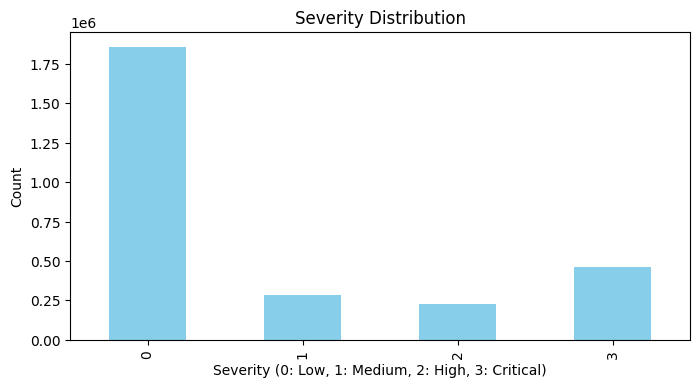

In [ ]:
# 2. Examine the Severity Distribution
severity_counts = combined_df['severity'].value_counts()
print("Severity distribution:")
print(severity_counts)

# Plot a bar chart for severity distribution
plt.figure(figsize=(8, 4))
severity_counts.sort_index().plot(kind='bar', color='skyblue')
plt.title("Severity Distribution")
plt.xlabel("Severity (0: Low, 1: Medium, 2: High, 3: Critical)")
plt.ylabel("Count")
plt.show()



Descriptive statistics for high-severity key features:
        Total Fwd Packets  Total Length of Fwd Packets  \
count       684713.000000                 6.847130e+05   
mean             7.996236                 6.869765e+02   
std            562.392706                 1.744727e+04   
min              1.000000                 0.000000e+00   
25%              2.000000                 1.200000e+01   
50%              2.000000                 4.800000e+01   
75%              4.000000                 9.200000e+01   
max         200755.000000                 1.290000e+07   

        Fwd Packet Length Max   Flow IAT Min   act_data_pkt_fwd  \
count           684713.000000   6.847130e+05      684713.000000   
mean               278.663168   7.630637e+04           5.507061   
std               1145.411245   1.926127e+06         538.695871   
min                  0.000000  -1.200000e+01           0.000000   
25%                  6.000000   3.000000e+00           1.000000   
50%                 

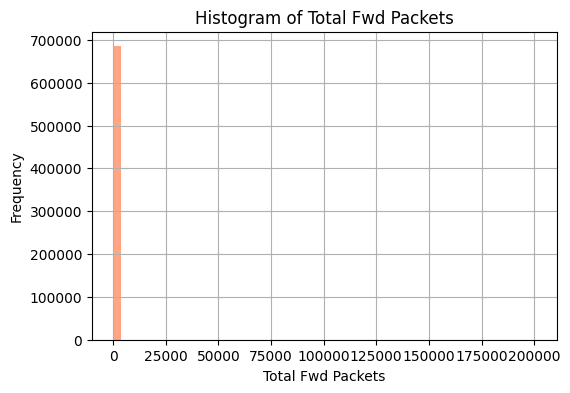

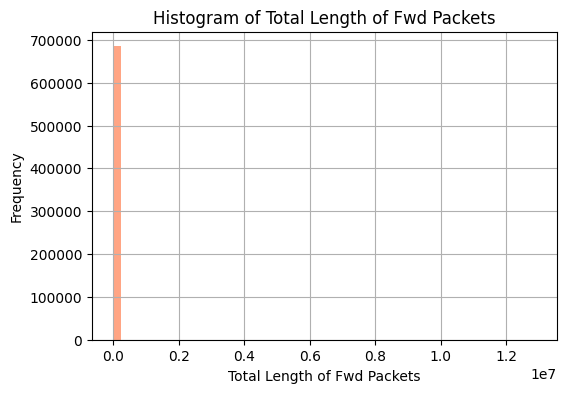

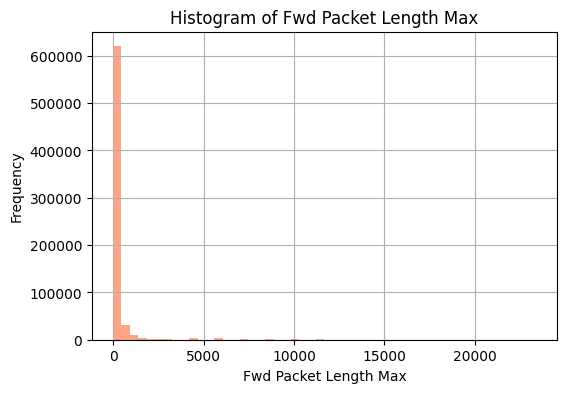

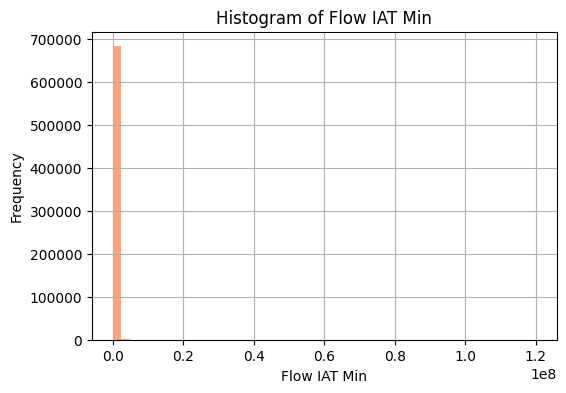

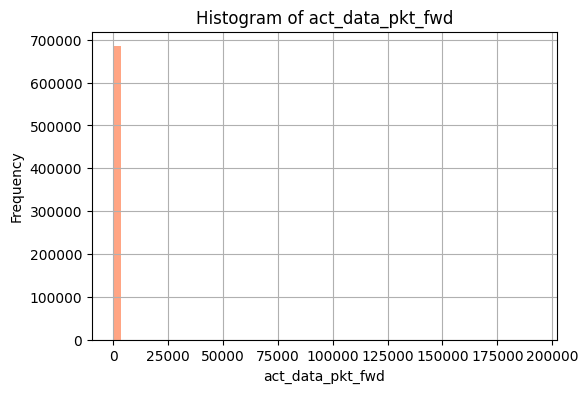

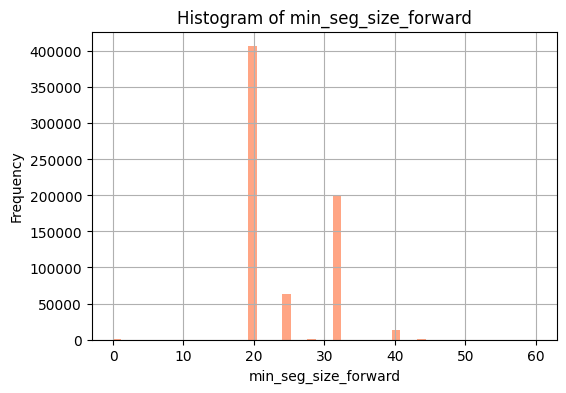

In [ ]:
# 3. Visualize the Distribution of Key Features for High-Severity Cases

# Filter data for high severity (assuming high severity are those with severity >= 2)
high_severity = combined_df[combined_df['severity'] >= 2]

# Define the key features you want to inspect
key_features = [
    ' Total Fwd Packets',
    'Total Length of Fwd Packets',
    ' Fwd Packet Length Max',
    ' Flow IAT Min',
    ' act_data_pkt_fwd',
    ' min_seg_size_forward'
]

print("Descriptive statistics for high-severity key features:")
print(high_severity[key_features].describe())

# Plot histograms for each key feature in high-severity cases
for feature in key_features:
    plt.figure(figsize=(6, 4))
    high_severity[feature].hist(bins=50, color='coral', alpha=0.7)
    plt.title(f"Histogram of {feature.strip()}")
    plt.xlabel(feature.strip())
    plt.ylabel("Frequency")
    plt.show()


# Observations

## Total Fwd Packets:
- Median: 2
- 75th Percentile: 4
- Max: 200,755
While there are extreme outliers (very high max), most high-severity samples show very low values (median of 2). This indicates that high-severity cases might be driven by a small number of samples with extreme values rather than a uniformly high count.

## Total Length of Fwd Packets:
- Median: 48
- 75th Percentile: 92
- Max: 12,900,000
Similarly, the bulk of the data is low (median 48), but a few outliers push the max very high.

## Fwd Packet Length Max:
- Median: 31
- 75th Percentile: 49
- Max: 23,360
Most high-severity samples have modest maximum packet lengths, but some are extremely high.

## Flow IAT Min:
- Median: 4
- 75th Percentile: 50
- Max: 120,000,000
Again, typical values are low even in high-severity cases, with extreme outliers present.

## act_data_pkt_fwd:
- Median: 1
- 75th Percentile: 3
- Max: 192,491
The majority of cases show very low forward data packet counts, with some very high outliers.

## min_seg_size_forward:
- Median: 20
- 75th Percentile: 32
- Max: 60
This feature shows less dramatic variation, with a relatively narrow range.

# Interpretation and Recommendations

1. **High-Severity Characteristics Are Not Uniformly Extreme:** Although some values can be very high (as seen in the max values), the typical (median) values for high-severity cases remain quite low. This suggests that the model may be learning that high-severity cases are not defined simply by extremely high numbers across all features, but by a subtle pattern in the multi-dimensional feature space.

2. **Multi-Feature Interactions Matter:** The parameter sweep you ran earlier showed that if you push one feature (like "Fwd Packet Length Max") to an extreme value, the model might still predict "Low." It indicates that a combination of features—rather than a single extreme value—is needed to shift the prediction toward higher severity.

3. **Testing for All Severity Levels:**
   - To detect severity levels 1 and 2 as well as 0 and 3, you should experiment with combinations that adjust multiple key features to values that are somewhat above their typical medians but not necessarily at the extreme end.
   - For instance, instead of setting "Total Fwd Packets" to 1000 (which might be too extreme compared to the median of 2), you might try values closer to the 75th or 90th percentile of high-severity cases (if available from further analysis).
   - Similarly, for "Fwd Packet Length Max," rather than extreme values, try moderate increases that reflect the subtle differences between classes.

# Step 2: Rebalance Your Training Data

* **Class Weights:** Compute class weights and pass them to your LightGBM classifier. This makes misclassifying minority classes more "costly" during training.

* **Mild Oversampling (if memory allows)**: If possible, try a memory-friendly oversampling method (like RandomOverSampler) on a subset of your data. However, using class weights is generally less memory intensive.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Columns in combined_df:
[' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', '

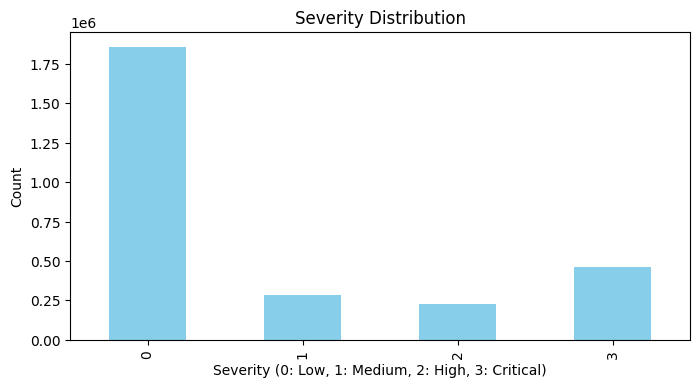

Descriptive statistics for high-severity key features:
        Total Fwd Packets  Total Length of Fwd Packets  \
count       684713.000000                 6.847130e+05   
mean             7.996236                 6.869765e+02   
std            562.392706                 1.744727e+04   
min              1.000000                 0.000000e+00   
25%              2.000000                 1.200000e+01   
50%              2.000000                 4.800000e+01   
75%              4.000000                 9.200000e+01   
max         200755.000000                 1.290000e+07   

        Fwd Packet Length Max   Flow IAT Min   act_data_pkt_fwd  \
count           684713.000000   6.847130e+05      684713.000000   
mean               278.663168   7.630637e+04           5.507061   
std               1145.411245   1.926127e+06         538.695871   
min                  0.000000  -1.200000e+01           0.000000   
25%                  6.000000   3.000000e+00           1.000000   
50%                 

In [2]:
import os
# Disable debugger file validation to reduce overhead in Colab
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from sklearn.utils.class_weight import compute_class_weight

# If using Google Drive, uncomment these lines:
from google.colab import drive
drive.mount('/content/drive')
# And set checkpoint paths accordingly

# 1. Define file paths (update paths as needed)
file_paths = [
    r"/content/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
    r"/content/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    r"/content/Friday-WorkingHours-Morning.pcap_ISCX.csv",
    r"/content/Monday-WorkingHours.pcap_ISCX.csv",
    r"/content/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
    r"/content/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
    r"/content/Tuesday-WorkingHours.pcap_ISCX.csv",
    r"/content/Wednesday-workingHours.pcap_ISCX.csv"
]

# 2. Define attack type mapping based on file names
attack_type_mapping = {
    "DDos": "DDos",
    "PortScan": "PortScan",
    "Infilteration": "Infilteration",
    "WebAttacks": "WebAttacks",
    "Morning": "Benign",
    "Afternoon": "Benign",
    "Monday": "Benign",
    "Tuesday": "Benign",
    "Wednesday": "Benign",
    "Thursday": "Benign",
    "Friday": "Benign"
}

# 3. Load and combine data
data_frames = []
for file_path in file_paths:
    df = pd.read_csv(file_path)
    # Assign attack type based on file name
    for key, value in attack_type_mapping.items():
        if key in file_path:
            df['attack_type'] = value
            break
    data_frames.append(df)
combined_df = pd.concat(data_frames, ignore_index=True)

# 4. Define severity mapping and apply it
severity_mapping = {
    "Benign": 0,
    "PortScan": 1,
    "Probe": 1,
    "DDos": 2,
    "Infilteration": 3,
    "WebAttacks": 3
}
combined_df['severity'] = combined_df['attack_type'].map(severity_mapping)

# 5. Data Cleaning: Replace infinite values and fill NaNs for numeric columns
combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)
numeric_cols = combined_df.select_dtypes(include=[np.number]).columns
combined_df[numeric_cols] = combined_df[numeric_cols].fillna(combined_df[numeric_cols].mean())

# 6. Examine columns and distribution
print("Columns in combined_df:")
print(combined_df.columns.tolist())

severity_counts = combined_df['severity'].value_counts()
print("Severity distribution:")
print(severity_counts)

plt.figure(figsize=(8, 4))
severity_counts.sort_index().plot(kind='bar', color='skyblue')
plt.title("Severity Distribution")
plt.xlabel("Severity (0: Low, 1: Medium, 2: High, 3: Critical)")
plt.ylabel("Count")
plt.show()

# 7. (Optional) Examine key feature distributions in high-severity cases
high_severity = combined_df[combined_df['severity'] >= 2]
key_features = [' Total Fwd Packets', 'Total Length of Fwd Packets',
                ' Fwd Packet Length Max', ' Flow IAT Min',
                ' act_data_pkt_fwd', ' min_seg_size_forward']
print("Descriptive statistics for high-severity key features:")
print(high_severity[key_features].describe())

# 8. Prepare Features and Target for Modeling
# Drop non-predictor columns: ' Label', 'attack_type', and 'severity'
X = combined_df.drop(columns=[' Label', 'attack_type', 'severity'])
y = combined_df['severity']
print("Number of predictor features:", X.shape[1])  # Expected: 78

# Save original feature column names for inference later
original_feature_columns = X.columns.tolist()
joblib.dump(original_feature_columns, 'original_feature_columns.pkl')
print("Original feature columns saved.")

In [3]:
# 9. Identify categorical and numerical features for preprocessing
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=[np.number]).columns

In [4]:
# 10. Build the Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [5]:
# 11. Compute Class Weights to Address Imbalance
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))
print("Class weights:", class_weights)
# Example output might be: {0: 0.38, 1: 2.47, 2: 3.13, 3: 1.54}

Class weights: {0: 0.38056562213810446, 1: 2.470391877598467, 2: 3.13489003078695, 3: 1.541906516358439}


In [6]:
# 12. Create a Pipeline with LightGBM Classifier Using Class Weights
lgb_model = lgb.LGBMClassifier(
    n_estimators=50,     # Using fewer trees for faster training and lower memory usage
    max_bin=255,         # Lowering max_bin to reduce memory usage
    random_state=42,
    n_jobs=-1,
    class_weight=class_weights
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb_model)
])

In [7]:
# 13. Split the Data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# OPTIONAL: For further memory safety or experimentation, use a subset of training data
sample_fraction = 0.1  # Use 10% of the training data for development
X_train_subset = X_train.sample(frac=sample_fraction, random_state=42)
y_train_subset = y_train.loc[X_train_subset.index]
print("Training subset shape:", X_train_subset.shape)

Training subset shape: (226459, 78)


In [8]:
# 14. Train the Model on the Selected Training Data (with class weights)
pipeline.fit(X_train_subset, y_train_subset)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14597
[LightGBM] [Info] Number of data points in the train set: 226459, number of used features: 70
[LightGBM] [Info] Start training from score -1.384360
[LightGBM] [Info] Start training from score -1.391803
[LightGBM] [Info] Start training from score -1.377794
[LightGBM] [Info] Start training from score -1.391287


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' B...
       ' min_seg_size_forward', 'Active Mean', ' Active Std', ' Active Max',
       ' Active Min', 'Idle Mean', ' Idle Std', ' Idle Max', ' Idle Min'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index([], dtype='object'))])),
                ('classifier',
                 LGBMClassifier(class_weight={0: 0.38056562213810446,
                                              1: 2.470391877598467,
                                              2: 3.13489003078695,
                                              3: 1.541906516358439},
                                max_bin=255, n_estimators=50, n_jobs=-1,
                                random_state=42))])

In [9]:
# 15. Evaluate the Model on the Validation Set
y_pred = pipeline.predict(X_val)
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.60      0.71    372690
           1       0.84      0.60      0.70     57321
           2       0.90      0.76      0.82     44869
           3       0.29      0.75      0.42     91269

    accuracy                           0.63    566149
   macro avg       0.73      0.67      0.66    566149
weighted avg       0.78      0.63      0.67    566149

Confusion Matrix:
[[222113   4491   2069 144017]
 [  7001  34229    220  15871]
 [  2961    380  33916   7612]
 [ 19501   1879   1442  68447]]


In [10]:
# 16. Save the Trained Pipeline and Numerical Scaler for Future Inference
joblib.dump(pipeline, 'model_cicids_lightgbm.pkl')
joblib.dump(preprocessor.named_transformers_['num'], 'scaler_cicids.pkl')
print("Pipeline and scaler saved as checkpoints.")

Pipeline and scaler saved as checkpoints.


# Classification Report Analysis

The classification report and confusion matrix indicate that while the model is performing reasonably well for classes 0, 1, and 2, it struggles with class 3 (Critical severity):

* **Class 3 (Critical):**
   * **Precision:** 0.29 – This means that when the model predicts class 3, only 29% of those predictions are correct (a high number of false positives).
   * **Recall:** 0.75 – It captures 75% of the actual class 3 samples, but with low precision, many non-critical cases are misclassified as critical.
* **Overall Accuracy:** 63%
* **Macro/Weighted Averages:** The macro average f1-score is 0.66 and the weighted average is 0.67, which indicates the imbalance and bias issues are affecting overall performance.

## Interpretation

* **Imbalance Issue:** The data is heavily imbalanced, with class 0 representing about 66% of samples. Even with class weights, the model may overcompensate and over-predict the minority class (here, class 3), leading to many false positives.
* **Threshold Sensitivity:** The decision threshold for class 3 might be too low, causing the classifier to label many borderline cases as critical. The model's probability outputs suggest that when it does predict class 3, it isn't very confident (only 29% precision).

# Calibrating Probabilities and Adjusting Thresholds

Calibrating probabilities and adjusting the threshold for class 3 can be done in a way that targets the minority class without drastically changing how the model treats the other classes. Here's what happens:

* **Probability Calibration:** Calibrating (using methods like isotonic regression or Platt scaling with CalibratedClassifierCV) adjusts the raw output probabilities for all classes so that they better reflect true likelihoods. This process is applied uniformly, so it doesn't inherently favor one class over another.

* **Threshold Adjustment:** When you adjust the threshold for class 3, you're essentially saying: "Only assign class 3 if its probability exceeds a certain level (say 0.4 or 0.5)." This decision rule can affect ambiguous cases—some instances that might have been predicted as class 3 by the default maximum probability rule might be re-assigned to another class if the class 3 probability is too low. With careful tuning, you can improve the precision for class 3 while minimally affecting the predictions for classes 0, 1, and 2.

In [11]:
import numpy as np
import pandas as pd
import joblib
from sklearn.calibration import CalibratedClassifierCV, FrozenEstimator
from sklearn.metrics import classification_report, confusion_matrix

# Load the trained pipeline and original feature names
pipeline = joblib.load('model_cicids_lightgbm.pkl')
original_feature_columns = joblib.load('original_feature_columns.pkl')

# Extract the preprocessor and the base classifier from the pipeline
preprocessor = pipeline.named_steps['preprocessor']
base_clf = pipeline.named_steps['classifier']

# Calibrate the classifier using FrozenEstimator to avoid the cv='prefit' deprecation warning
calibrated_clf = CalibratedClassifierCV(FrozenEstimator(base_clf), method='isotonic', cv='prefit')

# Use the preprocessor to transform a training subset (assuming X_train_subset and y_train_subset are defined)
# For example, if you used a subset during training:
# X_train_preprocessed = preprocessor.transform(X_train_subset)
# calibrated_clf.fit(X_train_preprocessed, y_train_subset)
#
# Alternatively, if you want to calibrate on the validation set (make sure to choose the appropriate dataset):
# Here, we assume X_train_subset and y_train_subset are available from earlier steps.
X_train_preprocessed = preprocessor.transform(X_train_subset)
calibrated_clf.fit(X_train_preprocessed, y_train_subset)

# Replace the classifier in the pipeline with the calibrated classifier
pipeline.steps[-1] = ('classifier', calibrated_clf)

# Define a custom prediction function that works on raw DataFrames (so the pipeline's preprocessor is applied)
def custom_predict(X, threshold=0.5):
    """
    Predict classes with a custom threshold for class 3.
    If the calibrated probability for class 3 is >= threshold, predict class 3.
    Otherwise, predict the class with the highest probability.

    X should be a DataFrame with the original feature columns.
    """
    probs = pipeline.predict_proba(X)
    preds = []
    for p in probs:
        # If class 3's probability is above the threshold, choose class 3
        if p[3] >= threshold:
            preds.append(3)
        else:
            preds.append(np.argmax(p))
    return np.array(preds)

# Instead of transforming X_val separately, call custom_predict on the raw X_val DataFrame.
custom_preds = custom_predict(X_val, threshold=0.5)  # Adjust threshold as needed
default_preds = pipeline.predict(X_val)

print("Default Prediction Report:")
print(classification_report(y_val, default_preds))
print("Default Confusion Matrix:")
print(confusion_matrix(y_val, default_preds))

print("\nCustom Threshold Prediction Report (threshold=0.5 for class 3):")
print(classification_report(y_val, custom_preds))
print("Custom Threshold Confusion Matrix:")
print(confusion_matrix(y_val, custom_preds))


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Default Prediction Report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87    372690
           1       0.97      0.57      0.72     57321
           2       0.97      0.74      0.84     44869
           3       0.94      0.17      0.29     91269

    accuracy                           0.80    566149
   macro avg       0.91      0.62      0.68    566149
weighted avg       0.83      0.80      0.76    566149

Default Confusion Matrix:
[[371040    320    432    898]
 [ 24408  32761     84     68]
 [ 11665     82  33095     27]
 [ 74335    580    514  15840]]

Custom Threshold Prediction Report (threshold=0.5 for class 3):
              precision    recall  f1-score   support

           0       0.77      1.00      0.87    372690
           1       0.97      0.57      0.72     57321
           2       0.97      0.74      0.84     44869
           3       0.94      0.17      0.29     91269

    accuracy                           0.80    566

# **Interpretation:**

**Low Confidence for Class 3:**
The calibrated probabilities for class 3 remain below 0.5 for all validation samples. Consequently, even when applying a custom threshold, the model defaults to the highest probability (argmax) decision, which results in the same predictions as the default setting.

**Impact on Evaluation:**
Your classification report shows that class 3 has a very low recall (0.17), meaning the model correctly identifies only 17% of actual class 3 instances, even though its precision is high (0.94). This is a common symptom of a model that is biased towards the majority class or not sufficiently sensitive to the minority (critical) class.

***CHATGPT recommended this***

I recommend first trying to lower the threshold for class 3—in your case, perhaps to around 0.3—and then re-evaluate the model's performance. This approach is a low-cost adjustment that may allow more instances to be classified as critical without having to retrain or overhaul your model immediately.

**Why Lower the Threshold?**

**Current Behavior:**
Your model's calibrated probabilities for class 3 are all below 0.5, so using the default threshold (or a threshold of 0.5) leads to no instances being classified as class 3.

**Expected Impact:**
Lowering the threshold (e.g., to 0.3) may capture borderline cases that, while not extremely confident, might actually be critical. This should increase recall for class 3, although you might see some drop in precision.

**Next Steps if Needed:**
If lowering the threshold improves recall but still isn’t sufficient, you can further refine the approach by:
* Adjusting class weights further (manually tweaking them)
* Fine-tuning hyperparameters (e.g., learning rate, max_depth, etc.)
* Enhancing feature engineering (adding interaction features or transformations)

In [17]:
import numpy as np
import pandas as pd
import joblib
from sklearn.calibration import CalibratedClassifierCV, FrozenEstimator
from sklearn.metrics import classification_report, confusion_matrix

# Load the trained pipeline and original feature names
pipeline = joblib.load('model_cicids_lightgbm.pkl')
original_feature_columns = joblib.load('original_feature_columns.pkl')

# Extract the preprocessor and the base classifier from the pipeline
preprocessor = pipeline.named_steps['preprocessor']
base_clf = pipeline.named_steps['classifier']

# Calibrate the classifier using CalibratedClassifierCV with FrozenEstimator
# This will adjust probability outputs using isotonic regression.
calibrated_clf = CalibratedClassifierCV(FrozenEstimator(base_clf), method='isotonic', cv='prefit')

# Use a training subset (or validation set) to calibrate:
# Here we assume X_train_subset and y_train_subset were defined earlier.
# If not, you can use any representative dataset.
X_train_subset_preprocessed = preprocessor.transform(X_train_subset)
calibrated_clf.fit(X_train_subset_preprocessed, y_train_subset)

# Replace the classifier in the pipeline with the calibrated classifier
pipeline.steps[-1] = ('classifier', calibrated_clf)

# Define a custom prediction function that applies a custom threshold for class 3.
def custom_predict(X, threshold=0.3):
    """
    Predict classes with a custom threshold for class 3.
    X should be a DataFrame with the original feature columns.
    If the calibrated probability for class 3 is >= threshold, predict class 3;
    otherwise, use the argmax of probabilities.
    """
    # The pipeline will apply the preprocessor automatically.
    probs = pipeline.predict_proba(X)
    preds = []
    for p in probs:
        # p[3] is the calibrated probability for class 3 (Critical)
        if p[3] >= threshold:
            preds.append(3)
        else:
            preds.append(np.argmax(p))
    return np.array(preds)

# Evaluate on the validation set using the default and custom threshold.
# Here, X_val should be a DataFrame with the original feature columns.
default_preds = pipeline.predict(X_val)
custom_preds = custom_predict(X_val, threshold=0.3)  # Using a threshold of 0.3 for class 3

print("Default Prediction Report:")
print(classification_report(y_val, default_preds))
print("Default Confusion Matrix:")
print(confusion_matrix(y_val, default_preds))

print("\nCustom Threshold Prediction Report (threshold=0.3 for class 3):")
print(classification_report(y_val, custom_preds))
print("Custom Threshold Confusion Matrix:")
print(confusion_matrix(y_val, custom_preds))


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Default Prediction Report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87    372690
           1       0.97      0.57      0.72     57321
           2       0.97      0.74      0.84     44869
           3       0.94      0.17      0.29     91269

    accuracy                           0.80    566149
   macro avg       0.91      0.62      0.68    566149
weighted avg       0.83      0.80      0.76    566149

Default Confusion Matrix:
[[371040    320    432    898]
 [ 24408  32761     84     68]
 [ 11665     82  33095     27]
 [ 74335    580    514  15840]]

Custom Threshold Prediction Report (threshold=0.3 for class 3):
              precision    recall  f1-score   support

           0       0.78      0.94      0.86    372690
           1       0.97      0.57      0.72     57321
           2       0.97      0.74      0.84     44869
           3       0.54      0.29      0.38     91269

    accuracy                           0.78    566

The calibrated model with a custom threshold of 0.3 for class 3 has changed the predictions notably:

**Class 3 (Critical Severity):**
* Default Model: Precision was 0.94 but recall was very low at 0.17, meaning it rarely predicted class 3 (with very high precision but missing many actual critical cases).
* Custom Threshold (0.3): Precision dropped to 0.54, but recall increased to 0.29. This means that while you're now catching more critical cases (higher recall), more of the predicted class 3 cases are false positives (lower precision).

**Overall Impact:**
* Accuracy: The overall accuracy decreased slightly from 80% to 78%.
* Macro Average: Macro recall improved (from 0.62 to 0.64) and macro f1 increased from 0.68 to 0.70, which suggests the model is slightly better balanced across classes.
* Weighted Metrics: The weighted averages are comparable, but note that the trade-off is that you're now detecting more critical cases at the expense of some precision.

**Confusion Matrix:**
* Many samples previously not predicted as critical are now being assigned to class 3. For example, class 0 has 20,150 misclassifications into class 3 compared to 898 previously.
* Similarly, classes 1 and 2 also have some misclassifications into class 3.

**Interpretation and Recommendations:**

**Trade-off:**
* Lowering the threshold for class 3 increases recall (you catch more critical cases), but at the cost of precision (more false positives). This trade-off is typical: if you want to be more sensitive to critical cases, you'll likely accept some extra false alarms.

**Threshold Fine-tuning:**
* You might experiment with thresholds between 0.3 and 0.5 to see if you can reach a better balance for class 3 without impacting the other classes too much. For instance, try 0.35 or 0.4 and review the changes in precision and recall.

**Application Consideration:**
* Depending on your application, you may prefer higher recall (to catch as many critical intrusions as possible) even if it means handling more false positives. In other situations, you might want to limit false alarms. The threshold can be tuned accordingly.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Testing threshold = 0.2 for Class 3

Threshold 0.2 - Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.65      0.74    372690
           1       0.97      0.57      0.72     57321
           2       0.97      0.74      0.84     44869
           3       0.30      0.70      0.42     91269

    accuracy                           0.66    566149
   macro avg       0.77      0.66      0.68    566149
weighted avg       0.78      0.66      0.69    566149

Threshold 0.2 - Confusion Matrix:
[[242195    307    411 129777]
 [ 10600  32722     83  13916]
 [  5321     81  33093   6374]
 [ 26358    529    490  63892]]

Testing threshold = 0.25 for Class 3

Threshold 0.25 - Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.85      0.83    372690
           1       0.97      0.57      0.72     57321
           2       0.97      0.74      0.84     44869
           3       0.39      0.44

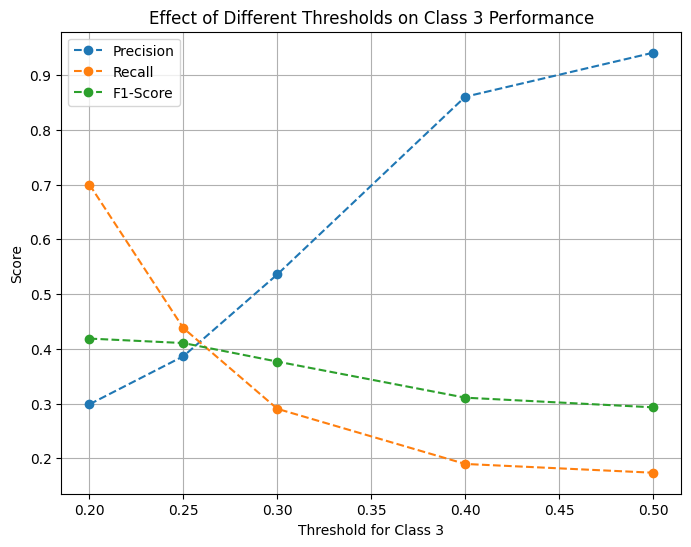

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Get predicted probabilities on the validation set
y_prob_val = pipeline.predict_proba(X_val)

# Step 2: Define a function to apply custom thresholds for class predictions
def custom_predict_with_thresholds(probabilities, thresholds):
    """
    Apply custom thresholds for class predictions.

    Arguments:
        probabilities (numpy array): Predicted probability distribution (n_samples x n_classes).
        thresholds (dict): Mapping of class labels to custom thresholds.

    Returns:
        numpy array: Array of predicted class labels after applying custom thresholds.
    """
    # Start with default predictions (argmax of probabilities)
    adjusted_preds = np.argmax(probabilities, axis=1)
    # For each class in thresholds, force the prediction if its probability exceeds the threshold
    for class_label, threshold in thresholds.items():
        # Identify samples where probability for the given class is >= threshold
        high_confidence = probabilities[:, class_label] >= threshold
        adjusted_preds[high_confidence] = class_label
    return adjusted_preds

# Step 3: Define threshold values for class 3 to test
threshold_values = [0.2, 0.25, 0.3, 0.4, 0.5]

results = []

# Step 4: Loop over the threshold values and evaluate the custom predictions
for threshold in threshold_values:
    print(f"\nTesting threshold = {threshold} for Class 3\n")

    # Apply the custom threshold for class 3 using our predicted probabilities
    custom_preds = custom_predict_with_thresholds(y_prob_val, {3: threshold})

    # Evaluate performance for class 3 using the classification report and confusion matrix
    report = classification_report(y_val, custom_preds, output_dict=True)
    confusion = confusion_matrix(y_val, custom_preds)

    # Extract metrics for class 3
    precision = report["3"]["precision"]
    recall = report["3"]["recall"]
    f1 = report["3"]["f1-score"]

    results.append((threshold, precision, recall, f1))

    # Print detailed evaluation for this threshold
    print(f"Threshold {threshold} - Classification Report:")
    print(classification_report(y_val, custom_preds))
    print(f"Threshold {threshold} - Confusion Matrix:")
    print(confusion)

# Step 5: Convert results to a NumPy array and plot the performance for class 3
results = np.array(results)

plt.figure(figsize=(8, 6))
plt.plot(results[:, 0], results[:, 1], label="Precision", marker='o', linestyle='dashed')
plt.plot(results[:, 0], results[:, 2], label="Recall", marker='o', linestyle='dashed')
plt.plot(results[:, 0], results[:, 3], label="F1-Score", marker='o', linestyle='dashed')
plt.xlabel("Threshold for Class 3")
plt.ylabel("Score")
plt.title("Effect of Different Thresholds on Class 3 Performance")
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Testing threshold = 0.2 for Class 3

Threshold 0.2 - Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.65      0.74    372690
           1       0.97      0.57      0.72     57321
           2       0.97      0.74      0.84     44869
           3       0.30      0.70      0.42     91269

    accuracy                           0.66    566149
   macro avg       0.77      0.66      0.68    566149
weighted avg       0.78      0.66      0.69    566149

Threshold 0.2 - Confusion Matrix:
[[242195    307    411 129777]
 [ 10600  32722     83  13916]
 [  5321     81  33093   6374]
 [ 26358    529    490  63892]]

Testing threshold = 0.22 for Class 3

Threshold 0.22 - Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79    372690
           1       0.97      0.57      0.72     57321
           2       0.97      0.74      0.84     44869
           3       0.33      0.57

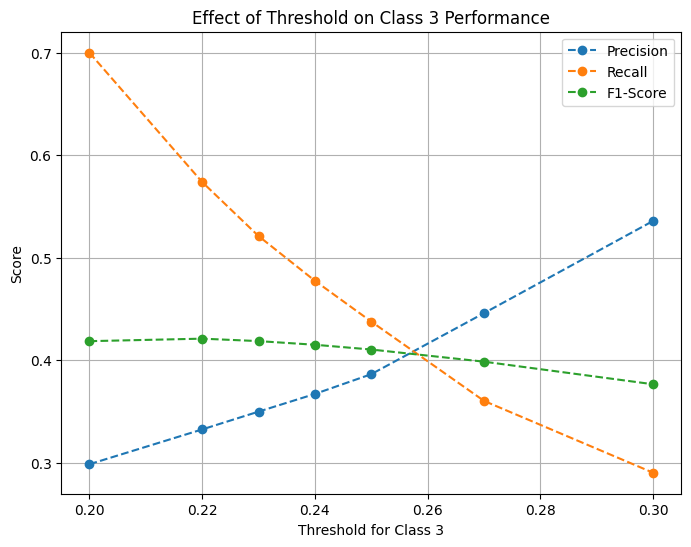

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Ensure that pipeline, X_val, and y_val are defined.
# For example, you might have loaded your pipeline like so:
# pipeline = joblib.load('model_cicids_lightgbm.pkl')
# and X_val, y_val were obtained from your train_test_split earlier.

# Step 1: Get predicted probabilities for the validation set
y_prob_val = pipeline.predict_proba(X_val)

# Step 2: Define a function to apply custom thresholds for class predictions.
def custom_predict_with_thresholds(probabilities, thresholds):
    """
    Apply custom thresholds for class predictions.

    Parameters:
        probabilities (numpy array): Array of predicted probability distributions (n_samples x n_classes).
        thresholds (dict): Dictionary mapping class labels to thresholds. Only applied for classes specified.

    Returns:
        numpy array: Array of predicted class labels after applying the custom thresholds.
    """
    # Start with default predictions (argmax of probabilities)
    adjusted_preds = np.argmax(probabilities, axis=1)
    # For each specified class, if its probability exceeds the threshold, force that class
    for class_label, threshold in thresholds.items():
        # Identify samples where the probability for the given class is >= threshold
        high_confidence = probabilities[:, class_label] >= threshold
        adjusted_preds[high_confidence] = class_label
    return adjusted_preds

# Step 3: Define the threshold values for class 3 that we want to test.
threshold_values = [0.2, 0.22, 0.23, 0.24, 0.25, 0.27, 0.3]

results = []  # To store the performance metrics for class 3

# Step 4: Loop over each threshold and evaluate performance.
for thresh in threshold_values:
    print(f"\nTesting threshold = {thresh} for Class 3\n")

    # Apply the custom prediction rule: only force class 3 if its probability is >= thresh.
    custom_preds = custom_predict_with_thresholds(y_prob_val, {3: thresh})

    # Get classification report (set output_dict=True to extract metrics for class 3)
    report = classification_report(y_val, custom_preds, output_dict=True)
    conf_mat = confusion_matrix(y_val, custom_preds)

    # Extract precision, recall, and F1-score for class 3
    precision = report["3"]["precision"]
    recall = report["3"]["recall"]
    f1 = report["3"]["f1-score"]
    results.append((thresh, precision, recall, f1))

    # Print the report and confusion matrix for this threshold
    print(f"Threshold {thresh} - Classification Report:")
    print(classification_report(y_val, custom_preds))
    print(f"Threshold {thresh} - Confusion Matrix:")
    print(conf_mat)

# Step 5: Convert the results to a NumPy array and plot the metrics for class 3.
results = np.array(results)  # Each row: [threshold, precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.plot(results[:, 0], results[:, 1], label="Precision", marker='o', linestyle='dashed')
plt.plot(results[:, 0], results[:, 2], label="Recall", marker='o', linestyle='dashed')
plt.plot(results[:, 0], results[:, 3], label="F1-Score", marker='o', linestyle='dashed')
plt.xlabel("Threshold for Class 3")
plt.ylabel("Score")
plt.title("Effect of Threshold on Class 3 Performance")
plt.legend()
plt.grid(True)
plt.show()



Testing threshold = 0.2 for Class 3

Threshold 0.2 - Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.65      0.74    372690
           1       0.97      0.57      0.72     57321
           2       0.97      0.74      0.84     44869
           3       0.30      0.70      0.42     91269

    accuracy                           0.66    566149
   macro avg       0.77      0.66      0.68    566149
weighted avg       0.78      0.66      0.69    566149

Threshold 0.2 - Confusion Matrix:
[[242195    307    411 129777]
 [ 10600  32722     83  13916]
 [  5321     81  33093   6374]
 [ 26358    529    490  63892]]

Testing threshold = 0.21 for Class 3

Threshold 0.21 - Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.71      0.77    372690
           1       0.97      0.57      0.72     57321
           2       0.97      0.74      0.84     44869
           3       0.32      0.63

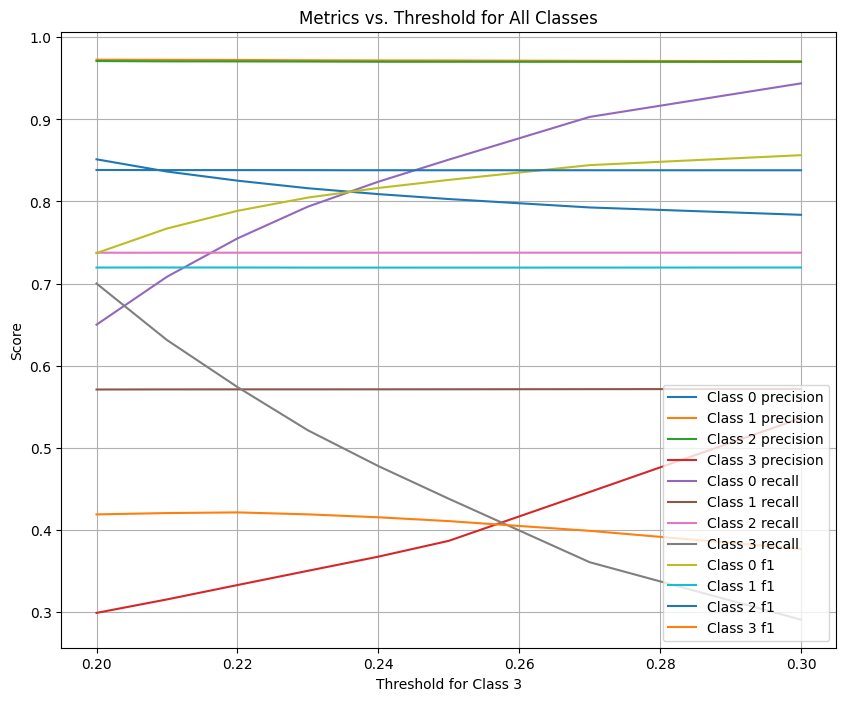

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Assuming y_prob_val, y_val, and the custom_predict_with_thresholds function are defined as before.
# (y_prob_val is obtained from: y_prob_val = pipeline.predict_proba(X_val))

# Define our custom prediction function (as before)
def custom_predict_with_thresholds(probabilities, thresholds):
    """
    Apply custom thresholds for class predictions.

    Arguments:
        probabilities (numpy array): Predicted probability distribution (n_samples x n_classes).
        thresholds (dict): Mapping of class labels to custom thresholds.

    Returns:
        numpy array: Array of predicted class labels after applying custom thresholds.
    """
    adjusted_preds = np.argmax(probabilities, axis=1)
    for class_label, threshold in thresholds.items():
        high_confidence = probabilities[:, class_label] >= threshold
        adjusted_preds[high_confidence] = class_label
    return adjusted_preds

# Define the range of thresholds for class 3 to test
threshold_values = [0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.27, 0.3]

# Store the metrics for all classes for each threshold
all_results = []

for threshold in threshold_values:
    print(f"\nTesting threshold = {threshold} for Class 3\n")

    # Apply the custom threshold for class 3
    custom_preds = custom_predict_with_thresholds(y_prob_val, {3: threshold})

    # Get the classification report and confusion matrix for all classes
    report = classification_report(y_val, custom_preds, output_dict=True)
    confusion = confusion_matrix(y_val, custom_preds)

    # Print the overall report and confusion matrix
    print(f"Threshold {threshold} - Classification Report:")
    print(classification_report(y_val, custom_preds))
    print(f"Threshold {threshold} - Confusion Matrix:")
    print(confusion)

    # Store the entire report for further analysis if needed
    all_results.append((threshold, report, confusion))

# Optionally, plot metrics for each class versus the threshold
# For example, extract precision, recall, and f1 for each class and plot them
import pandas as pd

metrics = {0: {"precision": [], "recall": [], "f1": []},
           1: {"precision": [], "recall": [], "f1": []},
           2: {"precision": [], "recall": [], "f1": []},
           3: {"precision": [], "recall": [], "f1": []}}

for threshold, report, _ in all_results:
    for cls in [0, 1, 2, 3]:
        metrics[cls]["precision"].append(report[str(cls)]["precision"])
        metrics[cls]["recall"].append(report[str(cls)]["recall"])
        metrics[cls]["f1"].append(report[str(cls)]["f1-score"])

thresholds = threshold_values
df_metrics = {}
for cls in [0, 1, 2, 3]:
    df_metrics[cls] = pd.DataFrame(metrics[cls], index=thresholds)

plt.figure(figsize=(10, 8))
for metric in ["precision", "recall", "f1"]:
    for cls in [0, 1, 2, 3]:
        plt.plot(thresholds, df_metrics[cls][metric], label=f"Class {cls} {metric}")
plt.xlabel("Threshold for Class 3")
plt.ylabel("Score")
plt.title("Metrics vs. Threshold for All Classes")
plt.legend()
plt.grid(True)
plt.show()


At threshold 0.2:

**Class 3:** Precision = 0.30, Recall = 0.70, F1 ≈ 0.42
**Interpretation:** The model is very sensitive—catching 70% of actual critical cases—but it has many false alarms (only 30% of its critical predictions are correct).

At threshold 0.21–0.23:

**Class 3:** Precision increases gradually (≈0.32–0.35) while recall drops to ≈0.57–0.52, with F1 remaining around 0.42.
**Overall Accuracy:** Increases from 66% at 0.2 to 72% at 0.23.
**Interpretation:** You get a more balanced trade-off—slightly fewer false positives but also fewer detected critical cases.

At threshold 0.24–0.25:

**Class 3:** Precision is slightly higher (0.37–0.39) and recall further drops (≈0.48–0.44), with F1 around 0.41.
**Overall Accuracy:** Rises further (74–75%).
**Interpretation:** The model becomes more conservative, improving precision but missing more critical cases.

At threshold 0.27–0.3:

**Class 3:** Precision increases noticeably (0.45 at 0.27, 0.54 at 0.3), but recall falls sharply (0.36 at 0.27, 0.29 at 0.3), with a lower F1 (≈0.40 or 0.38).
**Overall Accuracy:** Reaches 77–78%, largely because the model almost never predicts class 3.

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import joblib
import gc

# -----------------------------
# Assume combined_df is already loaded and preprocessed (steps 1-7)
# For example, combined_df has been created from your CSV files,
# and includes columns: predictor features, ' Label', 'attack_type', 'severity'

# 1. Prepare Features and Target
X = combined_df.drop(columns=[' Label', 'attack_type', 'severity'])
y = combined_df['severity']
print("Number of predictor features:", X.shape[1])  # Expected: 78

# Save original feature column names for later inference
original_feature_columns = X.columns.tolist()
joblib.dump(original_feature_columns, 'original_feature_columns.pkl')
print("Original feature columns saved.")

Number of predictor features: 78
Original feature columns saved.


In [4]:
# 2. Downcast Numeric Data to Reduce Memory Usage
def downcast_df(df):
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = df[float_cols].astype('float32')
    int_cols = df.select_dtypes(include=['int64']).columns
    df[int_cols] = df[int_cols].astype('int32')
    return df

X = downcast_df(X)

In [5]:
# 3. Identify Categorical and Numerical Features for Preprocessing
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=[np.number]).columns

In [6]:
# 4. Build the Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [7]:
# 5. Compute Class Weights to Address Imbalance
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))
print("Class weights:", class_weights)

Class weights: {0: 0.38056562213810446, 1: 2.470391877598467, 2: 3.13489003078695, 3: 1.541906516358439}


In [8]:
# 6. Create a Pipeline with LightGBM Classifier Using Class Weights
lgb_model = lgb.LGBMClassifier(
    n_estimators=50,    # Fewer trees for efficiency
    max_bin=255,
    random_state=42,
    n_jobs=-1,
    class_weight=class_weights
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb_model)
])

In [9]:
# 7. Split Data into Training and Validation Sets
# Use full X and y for splitting, then use a subset for tuning
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# 8. Use a Representative Subset for Hyperparameter Tuning (e.g., 10% of training data)
sample_fraction = 0.1
X_train_subset = X_train.sample(frac=sample_fraction, random_state=42)
y_train_subset = y_train.loc[X_train_subset.index]
print("Training subset shape:", X_train_subset.shape)

# Optional: Clear memory from full training data if needed
del X_train, y_train
gc.collect()

Training subset shape: (226459, 78)


3360

In [11]:
# 9. Define the Hyperparameter Search Space for LightGBM
param_distributions = {
    'classifier__n_estimators': [50, 75, 100],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__max_depth': [3, 5, 7, -1],  # -1 means no limit
    'classifier__min_child_samples': [10, 20, 50],
    'classifier__num_leaves': [31, 63, 127]
}

In [12]:
# 10. Set Up RandomizedSearchCV on the Subset
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=10,               # Number of parameter settings to sample
    scoring='f1_weighted',   # You may choose a scoring metric that emphasizes minority classes
    cv=3,                    # 3-fold cross-validation on the subset
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [13]:
# 11. Run the Randomized Search
random_search.fit(X_train_subset, y_train_subset)
print("Best parameters found:")
print(random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.171385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14597
[LightGBM] [Info] Number of data points in the train set: 226459, number of used features: 70
[LightGBM] [Info] Start training from score -1.384360
[LightGBM] [Info] Start training from score -1.391803
[LightGBM] [Info] Start training from score -1.377794
[LightGBM] [Info] Start training from score -1.391287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

In [14]:
# 12. Evaluate the Best Model on the Full Validation Set
best_pipeline = random_search.best_estimator_
y_pred = best_pipeline.predict(X_val)
print("Classification Report on Validation Set:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix on Validation Set:")
print(confusion_matrix(y_val, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.77      0.86      0.82    372690
           1       0.95      0.55      0.70     57321
           2       0.64      0.71      0.68     44869
           3       0.36      0.27      0.31     91269

    accuracy                           0.72    566149
   macro avg       0.68      0.60      0.62    566149
weighted avg       0.71      0.72      0.71    566149

Confusion Matrix on Validation Set:
[[321847   1257  13483  36103]
 [ 20493  31665    885   4278]
 [ 10536     57  31905   2371]
 [ 63434    336   3301  24198]]


In [16]:
# 13. Save the Tuned Model and Preprocessor
joblib.dump(best_pipeline, 'tuned_model_cicids_lightgbm.pkl')
fitted_scaler = best_pipeline.named_steps['preprocessor'].named_transformers_['num']
joblib.dump(fitted_scaler, 'tuned_scaler_cicids.pkl')
print("Tuned model and scaler saved as checkpoints.")

Tuned model and scaler saved as checkpoints.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

**Classification Report on Validation Set:**

              precision    recall  f1-score   support

           0       0.77      0.86      0.82    372690
           1       0.95      0.55      0.70     57321
           2       0.64      0.71      0.68     44869
           3       0.36      0.27      0.31     91269

```
    accuracy                           0.72    566149
   macro avg       0.68      0.60      0.62    566149
weighted avg       0.71      0.72      0.71    56614
```

9

**Confusion Matrix on Validation Set:**



```
 [[321847   1257  13483  36103]
 [ 20493  31665    885   4278]
 [ 10536     57  31905   2371]
 [ 63434    336   3301  24198]]
```



Number of predictor features: 78
Original feature columns saved.
Class weights: {0: 0.38056562213810446, 1: 2.470391877598467, 2: 3.13489003078695, 3: 1.541906516358439}
Training subset shape: (226459, 78)
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14597
[LightGBM] [Info] Number of data points in the train set: 226459, number of used features: 70
[LightGBM] [Info] Start training from score -1.384360
[LightGBM] [Info] Start training from score -1.391803
[LightGBM] [Info] Start training from score -1.377794
[LightGBM] [Info] Start training from score -1.391287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.77      0.86      0.82    372690
           1       0.95      0.55      0.70     57321
           2       0.64      0.71      0.68     44869
           3       0.36      0.27      0.31     91269

    accuracy                           0.72    566149
   macro avg       0.68      0.60      0.62    566149
weighted avg       0.71      0.72      0.71    566149

Confusion Matrix on Validation Set:
[[321847   1257  13483  36103]
 [ 20493  31665    885   4278]
 [ 10536     57  31905   2371]
 [ 63434    336   3301  24198]]
Tuned model and scaler saved as checkpoints.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Testing threshold = 0.2 for Class 3
Threshold 0.2 - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.09      0.17    372690
           1       0.98      0.55      0.71     57321
           2       0.95      0.42      0.58     44869
           3       0.19      1.00      0.32     91269

    accuracy                           0.31    566149
   macro avg       0.78      0.51      0.44    566149
weighted avg       0.86      0.31      0.28    566149

Threshold 0.2 - Confusion Matrix:
[[ 33681    197    882 337930]
 [    19  31615     54  25633]
 [    14     47  18833  25975]
 [    74    250     92  90853]]

Testing threshold = 0.21 for Class 3
Threshold 0.21 - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.09      0.17    372690
           1       0.98      0.55      0.71     57321
           2       0.94      0.42      0.58     44869
           3       0.19      0.99  

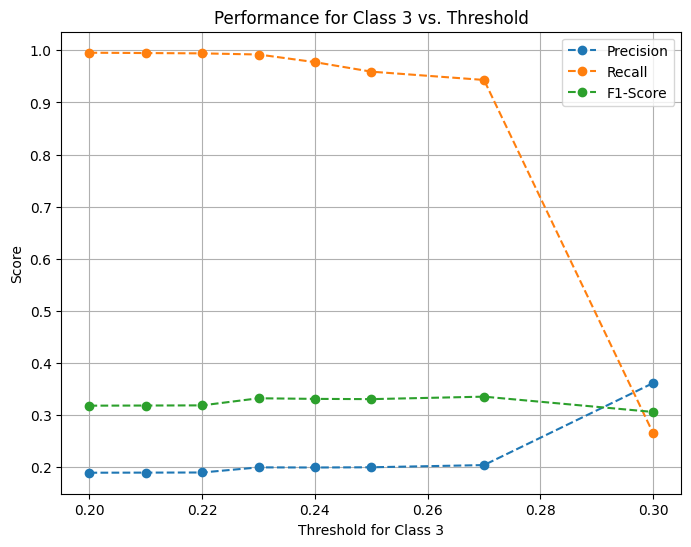

Number of misclassified critical cases: 529
          Destination Port   Flow Duration   Total Fwd Packets  \
1283805               2030              52                   1   
1283525              32776               3                   1   
1502416              61232          170272                   2   
1318333               7543          240061                   3   
1629406                443          117093                   1   

          Total Backward Packets  Total Length of Fwd Packets  \
1283805                        1                            2   
1283525                        1                            2   
1502416                        1                           12   
1318333                        0                           18   
1629406                        1                            0   

          Total Length of Bwd Packets   Fwd Packet Length Max  \
1283805                             6                       2   
1283525                             6 

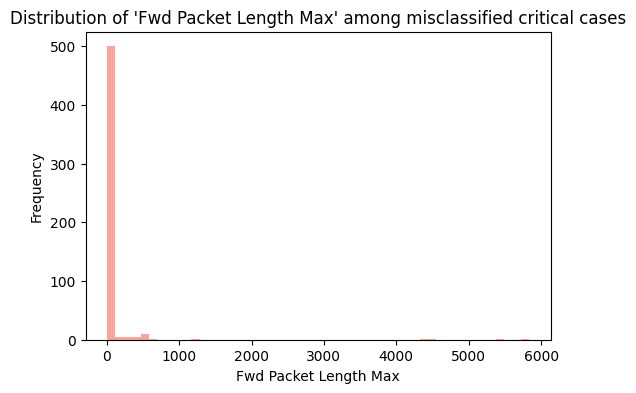

In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import joblib
import gc

# --- Assume combined_df is already loaded and preprocessed as before ---
# 1. Prepare Features and Target
X = combined_df.drop(columns=[' Label', 'attack_type', 'severity'])
y = combined_df['severity']
print("Number of predictor features:", X.shape[1])  # Expected: 78

# Save original feature names for inference later
original_feature_columns = X.columns.tolist()
joblib.dump(original_feature_columns, 'original_feature_columns.pkl')
print("Original feature columns saved.")

# 2. Downcast Numeric Data for Memory Efficiency
def downcast_df(df):
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = df[float_cols].astype('float32')
    int_cols = df.select_dtypes(include=['int64']).columns
    df[int_cols] = df[int_cols].astype('int32')
    return df

X = downcast_df(X)

# 3. Identify Categorical and Numerical Features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=[np.number]).columns

# 4. Build the Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 5. Compute Class Weights to Address Imbalance
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))
print("Class weights:", class_weights)

# 6. Create a Pipeline with LightGBM Classifier Using Class Weights
lgb_model = lgb.LGBMClassifier(
    n_estimators=50,
    max_bin=255,
    random_state=42,
    n_jobs=-1,
    class_weight=class_weights
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb_model)
])

# 7. Split Data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Use a Representative Subset for Tuning (e.g., 10%)
sample_fraction = 0.1
X_train_subset = X_train.sample(frac=sample_fraction, random_state=42)
y_train_subset = y_train.loc[X_train_subset.index]
print("Training subset shape:", X_train_subset.shape)
del X_train, y_train
gc.collect()

# 9. Define the Hyperparameter Search Space (including max_depth of 3,4,5)
param_distributions = {
    'classifier__n_estimators': [50, 75, 100],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__max_depth': [3, 4, 5, -1],  # -1 means no limit
    'classifier__min_child_samples': [10, 20, 50],
    'classifier__num_leaves': [31, 63, 127]
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_subset, y_train_subset)
print("Best parameters found:")
print(random_search.best_params_)

# 10. Retrieve the Best Pipeline and Evaluate on the Full Validation Set
best_pipeline = random_search.best_estimator_
y_pred = best_pipeline.predict(X_val)
print("Classification Report on Validation Set:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix on Validation Set:")
print(confusion_matrix(y_val, y_pred))

# Save the tuned model and the fitted numerical scaler from the pipeline
joblib.dump(best_pipeline, 'tuned_model_cicids_lightgbm.pkl')
fitted_scaler = best_pipeline.named_steps['preprocessor'].named_transformers_['num']
joblib.dump(fitted_scaler, 'tuned_scaler_cicids.pkl')
print("Tuned model and scaler saved as checkpoints.")

# 11. Calibrate the Model's Probabilities (if desired)
# Here we assume you already calibrated your model earlier. This example shows a custom threshold function.

def custom_predict(X, threshold=0.22):
    """
    Custom prediction: if the calibrated probability for class 3 is above the threshold,
    force the prediction to class 3, otherwise use the default argmax.
    X should be a DataFrame with original feature columns.
    """
    probs = best_pipeline.predict_proba(X)
    preds = np.argmax(probs, axis=1)
    preds[probs[:, 3] >= threshold] = 3
    return preds

# 12. Evaluate with Custom Threshold and Analyze Impact on All Classes
# Get predicted probabilities on the validation set
y_prob_val = best_pipeline.predict_proba(X_val)

# Loop over thresholds from 0.2 to 0.3 (e.g., 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.27, 0.3)
threshold_values = [0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.27, 0.3]
results = []

def custom_predict_with_thresholds(probabilities, thresholds):
    adjusted_preds = np.argmax(probabilities, axis=1)
    for class_label, threshold in thresholds.items():
        high_confidence = probabilities[:, class_label] >= threshold
        adjusted_preds[high_confidence] = class_label
    return adjusted_preds

for threshold in threshold_values:
    print(f"\nTesting threshold = {threshold} for Class 3")
    custom_preds = custom_predict_with_thresholds(y_prob_val, {3: threshold})
    report = classification_report(y_val, custom_preds, output_dict=True)
    confusion = confusion_matrix(y_val, custom_preds)
    results.append((threshold, report["3"]["precision"], report["3"]["recall"], report["3"]["f1-score"]))
    print(f"Threshold {threshold} - Classification Report:")
    print(classification_report(y_val, custom_preds))
    print(f"Threshold {threshold} - Confusion Matrix:")
    print(confusion)

# Plot performance for class 3
results = np.array(results)
plt.figure(figsize=(8, 6))
plt.plot(results[:, 0], results[:, 1], label="Precision", marker='o', linestyle='dashed')
plt.plot(results[:, 0], results[:, 2], label="Recall", marker='o', linestyle='dashed')
plt.plot(results[:, 0], results[:, 3], label="F1-Score", marker='o', linestyle='dashed')
plt.xlabel("Threshold for Class 3")
plt.ylabel("Score")
plt.title("Performance for Class 3 vs. Threshold")
plt.legend()
plt.grid(True)
plt.show()

# 13. Analyze Misclassified Critical Cases (Class 3)
# Find instances where true label is 3 but prediction is not 3 (using the chosen threshold, say 0.22)
chosen_threshold = 0.22
custom_preds_final = custom_predict_with_thresholds(y_prob_val, {3: chosen_threshold})
misclassified_critical = X_val[(y_val == 3) & (custom_preds_final != 3)]
print("Number of misclassified critical cases:", misclassified_critical.shape[0])
print(misclassified_critical.head())

# Optionally, visualize key feature distributions among misclassified critical cases
plt.figure(figsize=(6, 4))
plt.hist(misclassified_critical[' Fwd Packet Length Max'], bins=50, color='salmon', alpha=0.7)
plt.title("Distribution of 'Fwd Packet Length Max' among misclassified critical cases")
plt.xlabel("Fwd Packet Length Max")
plt.ylabel("Frequency")
plt.show()


**Threshold Tuning (Completed):**

Identified that a threshold around 0.22–0.23 offers a balanced trade-off for class 3.

**Misclassification Analysis (Completed):**

Extracted misclassified critical cases and have a starting point to analyze the differences.


Number of misclassified critical cases: 529
Number of correctly classified critical cases: 90740


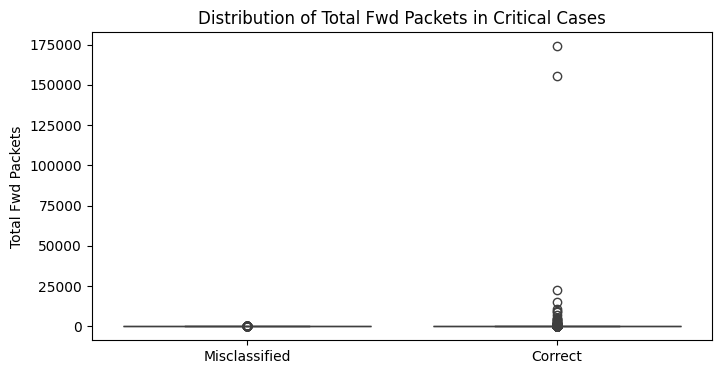

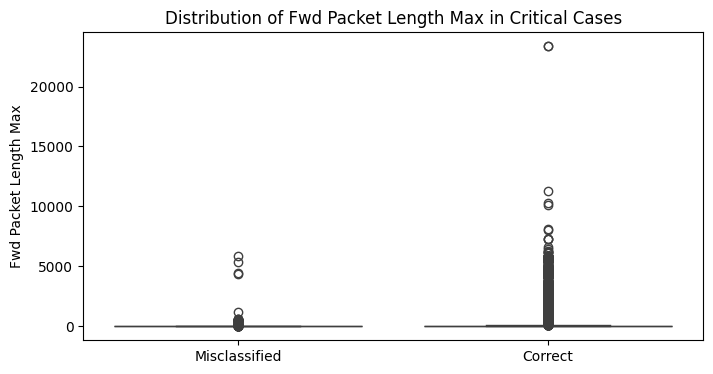

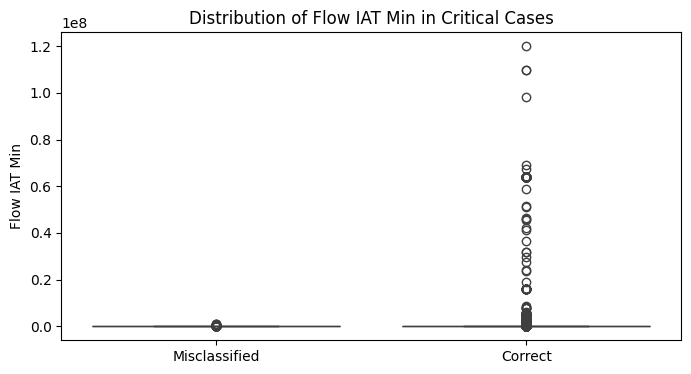

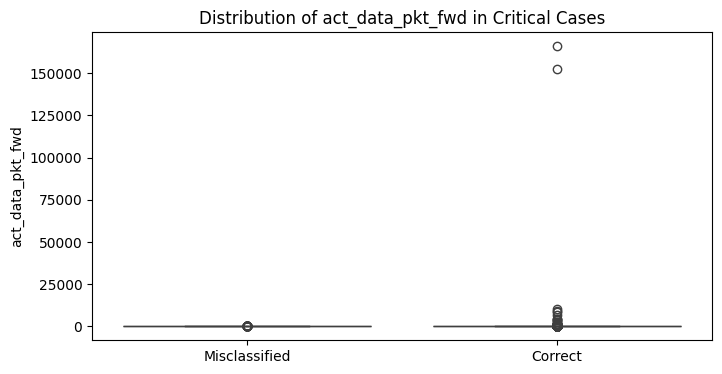

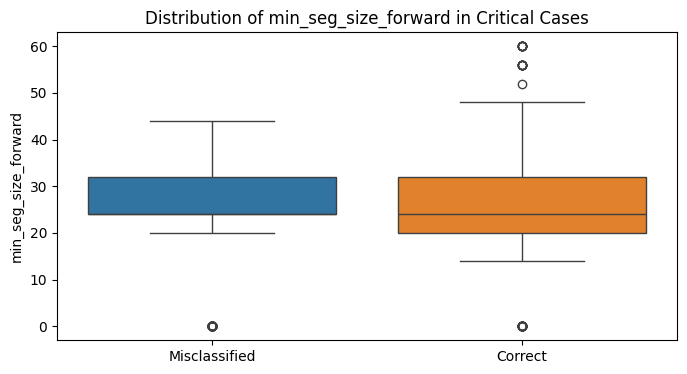

Descriptive statistics for misclassified critical cases:
       Total Fwd Packets  Fwd Packet Length Max   Flow IAT Min  \
count         529.000000             529.000000     529.000000   
mean           16.633270              60.502836   27393.068053   
std            45.554556             449.340907   93203.611641   
min             1.000000               0.000000       0.000000   
25%             1.000000               0.000000       4.000000   
50%             2.000000               0.000000      49.000000   
75%             4.000000               2.000000   15101.000000   
max           327.000000            5840.000000  996259.000000   

       act_data_pkt_fwd  min_seg_size_forward  
count        529.000000            529.000000  
mean           0.427221             24.544423  
std            1.546898             10.198337  
min            0.000000              0.000000  
25%            0.000000             24.000000  
50%            0.000000             24.000000  
75%         

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume these variables are already defined:
# best_pipeline, X_val, y_val, y_prob_val
# And your custom prediction function from before:
def custom_predict_with_thresholds(probabilities, thresholds):
    adjusted_preds = np.argmax(probabilities, axis=1)
    for class_label, threshold in thresholds.items():
        high_confidence = probabilities[:, class_label] >= threshold
        adjusted_preds[high_confidence] = class_label
    return adjusted_preds

# Set your chosen threshold for class 3
chosen_threshold = 0.22
custom_preds = custom_predict_with_thresholds(y_prob_val, {3: chosen_threshold})

# Extract misclassified critical cases (true label 3 but predicted != 3)
misclassified_critical = X_val[(y_val == 3) & (custom_preds != 3)]
# Extract correctly classified critical cases (true label 3 and predicted as 3)
correctly_classified_critical = X_val[(y_val == 3) & (custom_preds == 3)]

print("Number of misclassified critical cases:", misclassified_critical.shape[0])
print("Number of correctly classified critical cases:", correctly_classified_critical.shape[0])

# Select key features for analysis; adjust feature names as needed
key_features = [
    ' Total Fwd Packets',
    ' Fwd Packet Length Max',
    ' Flow IAT Min',
    ' act_data_pkt_fwd',
    ' min_seg_size_forward'
]

# Compare distributions using boxplots
for feature in key_features:
    plt.figure(figsize=(8, 4))
    # Create a DataFrame combining the values for misclassified and correctly classified cases
    comparison_df = pd.concat([
        misclassified_critical[feature].rename('Misclassified'),
        correctly_classified_critical[feature].rename('Correct')
    ], axis=1)
    sns.boxplot(data=comparison_df)
    plt.title(f"Distribution of {feature.strip()} in Critical Cases")
    plt.ylabel(feature.strip())
    plt.show()

# Print descriptive statistics for further insights
print("Descriptive statistics for misclassified critical cases:")
print(misclassified_critical[key_features].describe())
print("\nDescriptive statistics for correctly classified critical cases:")
print(correctly_classified_critical[key_features].describe())


The descriptive statistics indicate clear differences between the misclassified critical cases (true label 3 but not predicted as 3) and the correctly classified critical cases. Here’s a summary of the key observations and what they might suggest:

**Key Observations**

**Total Fwd Packets:**
* Misclassified: Mean ≈ 16.63, median ≈ 2
* Correctly Classified: Mean ≈ 10.70, median ≈ 2
* **Interpretation:** Both groups have low median values, but the misclassified cases show a higher mean—likely driven by a few outliers. This could indicate some misclassified samples are occurring when there’s an unusual spike in forward packets.

**Fwd Packet Length Max:**
* Misclassified: Mean ≈ 60.50, median = 0, 75th percentile = 2
* Correctly Classified: Mean ≈ 151.23, median = 36, 75th percentile = 53
* **Interpretation:** Correctly classified critical cases tend to have higher maximum packet lengths, suggesting that longer packets may be a signal for critical events. The misclassified ones having near-zero median values may indicate that the model is missing critical cases that don't exhibit this behavior.

**Flow IAT Min:**
* Misclassified: Mean ≈ 27,393, median = 49
* Correctly Classified: Mean ≈ 100,009, median = 4
* **Interpretation:** There’s a huge variance here. The misclassified cases have a much lower median, which might be due to a few extreme values affecting the mean. This inconsistency suggests that the interarrival times might be noisy or that their interpretation varies among critical events.

**act_data_pkt_fwd:**
* Misclassified: Mean ≈ 0.43, median = 0
* Correctly Classified: Mean ≈ 7.51, median = 1
* **Interpretation:** This feature shows a stark difference. Correctly classified cases have noticeably higher forward data packet activity compared to misclassified ones. The model might be missing critical cases where this activity is very low.

**min_seg_size_forward:**
* The distributions are quite similar between the two groups, with a median of 24 and similar interquartile ranges.
* **Interpretation:** This feature might be less influential in distinguishing the two groups.

Number of predictor features: 81
Original feature columns saved.
Class weights: {0: 0.38056562213810446, 1: 2.470391877598467, 2: 3.13489003078695, 3: 1.541906516358439}
Training subset shape: (226459, 81)
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.193265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15362
[LightGBM] [Info] Number of data points in the train set: 226459, number of used features: 73
[LightGBM] [Info] Start training from score -1.384360
[LightGBM] [Info] Start training from score -1.391803
[LightGBM] [Info] Start training from score -1.377794
[LightGBM] [Info] Start training from score -1.391287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.77      0.86      0.82    372690
           1       0.95      0.55      0.70     57321
           2       0.65      0.71      0.68     44869
           3       0.36      0.27      0.31     91269

    accuracy                           0.72    566149
   macro avg       0.68      0.60      0.62    566149
weighted avg       0.71      0.72      0.71    566149

Confusion Matrix on Validation Set:
[[322064   1256  13265  36105]
 [ 20494  31665    884   4278]
 [ 10540     57  31901   2371]
 [ 63473    336   3262  24198]]
Tuned model and scaler saved as checkpoints.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Testing threshold = 0.2 for Class 3
Threshold 0.2 - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.09      0.17    372690
           1       0.98      0.55      0.71     57321
           2       0.95      0.42      0.58     44869
           3       0.19      1.00      0.32     91269

    accuracy                           0.31    566149
   macro avg       0.78      0.51      0.44    566149
weighted avg       0.86      0.31      0.28    566149

Threshold 0.2 - Confusion Matrix:
[[ 33687    197    881 337925]
 [    19  31615     51  25636]
 [    14     47  18833  25975]
 [    74    250     92  90853]]

Testing threshold = 0.21 for Class 3
Threshold 0.21 - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.09      0.17    372690
           1       0.98      0.55      0.71     57321
           2       0.94      0.42      0.58     44869
           3       0.19      0.99  

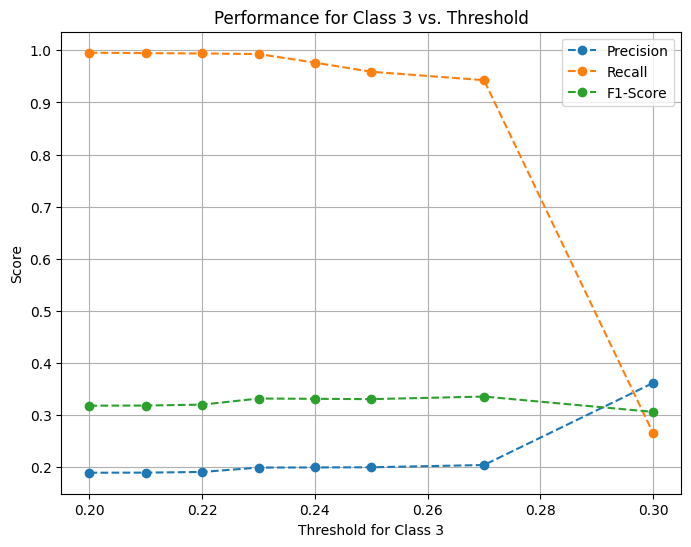

Number of misclassified critical cases: 545
Number of correctly classified critical cases: 90724


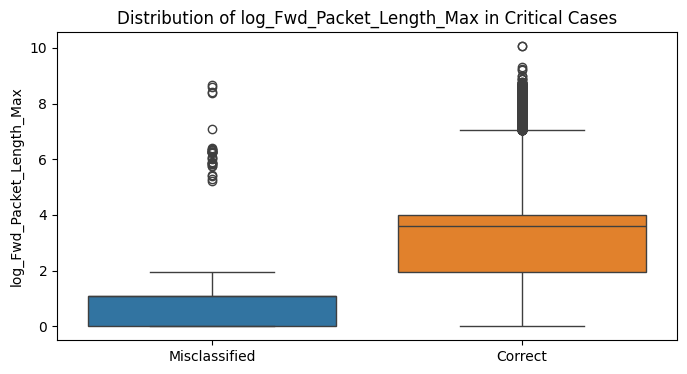

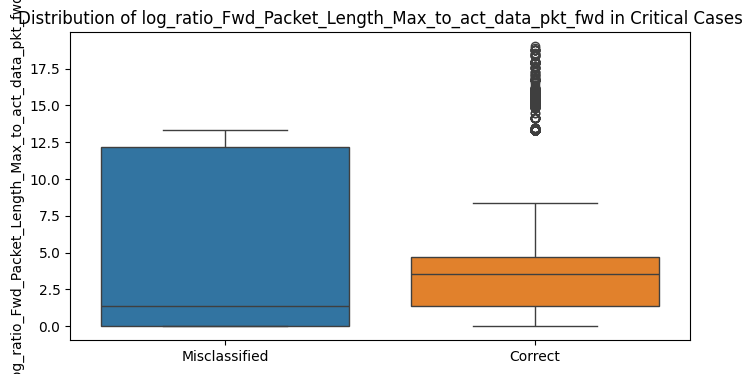

Descriptive statistics for engineered features in misclassified critical cases:
       log_Fwd_Packet_Length_Max  \
count                 545.000000   
mean                    0.927791   
std                     1.487791   
min                     0.000000   
25%                     0.000000   
50%                     1.098612   
75%                     1.098612   
max                     8.672657   

       log_ratio_Fwd_Packet_Length_Max_to_act_data_pkt_fwd  
count                                         545.000000    
mean                                            4.877411    
std                                             5.713331    
min                                             0.000000    
25%                                             0.000000    
50%                                             1.386291    
75%                                            12.206078    
max                                            13.304687    

Descriptive statistics for engineered feature

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import joblib
import gc

# Disable debugger file validation to reduce overhead in Colab
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"

# ---------------------------
# 1. Load and combine data from CSVs
file_paths = [
    r"/content/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
    r"/content/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    r"/content/Friday-WorkingHours-Morning.pcap_ISCX.csv",
    r"/content/Monday-WorkingHours.pcap_ISCX.csv",
    r"/content/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
    r"/content/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
    r"/content/Tuesday-WorkingHours.pcap_ISCX.csv",
    r"/content/Wednesday-workingHours.pcap_ISCX.csv"
]

attack_type_mapping = {
    "DDos": "DDos",
    "PortScan": "PortScan",
    "Infilteration": "Infilteration",
    "WebAttacks": "WebAttacks",
    "Morning": "Benign",
    "Afternoon": "Benign",
    "Monday": "Benign",
    "Tuesday": "Benign",
    "Wednesday": "Benign",
    "Thursday": "Benign",
    "Friday": "Benign"
}

data_frames = []
for file_path in file_paths:
    df = pd.read_csv(file_path)
    # Assign attack type based on file name
    for key, value in attack_type_mapping.items():
        if key in file_path:
            df['attack_type'] = value
            break
    data_frames.append(df)
combined_df = pd.concat(data_frames, ignore_index=True)

# ---------------------------
# 2. Define severity mapping and apply it
severity_mapping = {
    "Benign": 0,
    "PortScan": 1,
    "Probe": 1,
    "DDos": 2,
    "Infilteration": 3,
    "WebAttacks": 3
}
combined_df['severity'] = combined_df['attack_type'].map(severity_mapping)

# ---------------------------
# 3. Data Cleaning: Replace inf and fill NaNs for numeric columns
combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)
numeric_cols = combined_df.select_dtypes(include=[np.number]).columns
combined_df[numeric_cols] = combined_df[numeric_cols].fillna(combined_df[numeric_cols].mean())

# ---------------------------
# 4. Feature Engineering (Do this BEFORE splitting)
# Apply log transformation to "Fwd Packet Length Max"
# Using np.log1p to safely handle zero values.
combined_df['log_Fwd_Packet_Length_Max'] = np.log1p(combined_df[' Fwd Packet Length Max'])

# Create an interaction feature: Ratio of "Fwd Packet Length Max" to "act_data_pkt_fwd"
# Add a small constant to avoid division by zero.
combined_df['Fwd_Packet_Length_Max_to_act_data_pkt_fwd'] = combined_df[' Fwd Packet Length Max'] / (combined_df[' act_data_pkt_fwd'] + 1e-5)

# Also create a log transformation of the ratio
combined_df['log_ratio_Fwd_Packet_Length_Max_to_act_data_pkt_fwd'] = np.log1p(combined_df['Fwd_Packet_Length_Max_to_act_data_pkt_fwd'])

# ---------------------------
# 5. Prepare Features and Target for Modeling
# Drop non-predictor columns: ' Label', 'attack_type', and 'severity'
X = combined_df.drop(columns=[' Label', 'attack_type', 'severity'])
y = combined_df['severity']
print("Number of predictor features:", X.shape[1])  # Expected: 78

# Save original feature column names for later inference
original_feature_columns = X.columns.tolist()
joblib.dump(original_feature_columns, 'original_feature_columns.pkl')
print("Original feature columns saved.")

# ---------------------------
# 6. Downcast Numeric Data for Memory Efficiency
def downcast_df(df):
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = df[float_cols].astype('float32')
    int_cols = df.select_dtypes(include=['int64']).columns
    df[int_cols] = df[int_cols].astype('int32')
    return df

X = downcast_df(X)

# ---------------------------
# 7. Identify Categorical and Numerical Features for Preprocessing
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=[np.number]).columns

# ---------------------------
# 8. Build the Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# ---------------------------
# 9. Compute Class Weights to Address Imbalance
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))
print("Class weights:", class_weights)

# ---------------------------
# 10. Create a Pipeline with LightGBM Classifier Using Class Weights
lgb_model = lgb.LGBMClassifier(
    n_estimators=50,
    max_bin=255,
    random_state=42,
    n_jobs=-1,
    class_weight=class_weights
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb_model)
])

# ---------------------------
# 11. Split Data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------
# 12. Use a Representative Subset for Hyperparameter Tuning (e.g., 10% of training data)
sample_fraction = 0.1
X_train_subset = X_train.sample(frac=sample_fraction, random_state=42)
y_train_subset = y_train.loc[X_train_subset.index]
print("Training subset shape:", X_train_subset.shape)
del X_train, y_train
gc.collect()

# ---------------------------
# 13. Define the Hyperparameter Search Space for LightGBM
param_distributions = {
    'classifier__n_estimators': [50, 75, 100],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__max_depth': [3, 4, 5, -1],
    'classifier__min_child_samples': [10, 20, 50],
    'classifier__num_leaves': [31, 63, 127]
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_subset, y_train_subset)
print("Best parameters found:")
print(random_search.best_params_)

# ---------------------------
# 14. Retrieve the Best Pipeline and Evaluate on the Full Validation Set
best_pipeline = random_search.best_estimator_
y_pred = best_pipeline.predict(X_val)
print("Classification Report on Validation Set:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix on Validation Set:")
print(confusion_matrix(y_val, y_pred))

# Save the tuned model and fitted numerical scaler
joblib.dump(best_pipeline, 'tuned_model_cicids_lightgbm.pkl')
fitted_scaler = best_pipeline.named_steps['preprocessor'].named_transformers_['num']
joblib.dump(fitted_scaler, 'tuned_scaler_cicids.pkl')
print("Tuned model and scaler saved as checkpoints.")

# ---------------------------
# 15. Optional: Calibrate the Model's Probabilities & Perform Threshold Calibration
# Assume you have a custom prediction function defined previously.
# For example, using the custom_predict_with_thresholds function defined earlier:
def custom_predict_with_thresholds(probabilities, thresholds):
    adjusted_preds = np.argmax(probabilities, axis=1)
    for class_label, threshold in thresholds.items():
        high_confidence = probabilities[:, class_label] >= threshold
        adjusted_preds[high_confidence] = class_label
    return adjusted_preds

# Obtain predicted probabilities on the validation set
y_prob_val = best_pipeline.predict_proba(X_val)

# Test a range of thresholds for class 3
threshold_values = [0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.27, 0.3]
results = []

for threshold in threshold_values:
    print(f"\nTesting threshold = {threshold} for Class 3")
    custom_preds = custom_predict_with_thresholds(y_prob_val, {3: threshold})
    report = classification_report(y_val, custom_preds, output_dict=True)
    confusion = confusion_matrix(y_val, custom_preds)
    results.append((threshold, report["3"]["precision"], report["3"]["recall"], report["3"]["f1-score"]))
    print(f"Threshold {threshold} - Classification Report:")
    print(classification_report(y_val, custom_preds))
    print(f"Threshold {threshold} - Confusion Matrix:")
    print(confusion)

# Plot performance for class 3
results = np.array(results)
plt.figure(figsize=(8, 6))
plt.plot(results[:, 0], results[:, 1], label="Precision", marker='o', linestyle='dashed')
plt.plot(results[:, 0], results[:, 2], label="Recall", marker='o', linestyle='dashed')
plt.plot(results[:, 0], results[:, 3], label="F1-Score", marker='o', linestyle='dashed')
plt.xlabel("Threshold for Class 3")
plt.ylabel("Score")
plt.title("Performance for Class 3 vs. Threshold")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# 16. Analyze Misclassified Critical Cases for Feature Engineering
chosen_threshold = 0.22
custom_preds_final = custom_predict_with_thresholds(y_prob_val, {3: chosen_threshold})
misclassified_critical = X_val[(y_val == 3) & (custom_preds_final != 3)]
correctly_classified_critical = X_val[(y_val == 3) & (custom_preds_final == 3)]
print("Number of misclassified critical cases:", misclassified_critical.shape[0])
print("Number of correctly classified critical cases:", correctly_classified_critical.shape[0])

# Compare engineered features among misclassified vs. correctly classified
new_features = ['log_Fwd_Packet_Length_Max', 'log_ratio_Fwd_Packet_Length_Max_to_act_data_pkt_fwd']
for feature in new_features:
    plt.figure(figsize=(8, 4))
    comp_df = pd.concat([
        misclassified_critical[feature].rename('Misclassified'),
        correctly_classified_critical[feature].rename('Correct')
    ], axis=1)
    sns.boxplot(data=comp_df)
    plt.title(f"Distribution of {feature} in Critical Cases")
    plt.ylabel(feature)
    plt.show()

print("Descriptive statistics for engineered features in misclassified critical cases:")
print(misclassified_critical[new_features].describe())
print("\nDescriptive statistics for engineered features in correctly classified critical cases:")
print(correctly_classified_critical[new_features].describe())


**log_Fwd_Packet_Length_Max:**

* Misclassified Critical Cases: Mean ≈ 0.93, median ≈ 1.10
* Correctly Classified Critical Cases: Mean ≈ 3.27, median ≈ 3.61
* This suggests that correctly classified critical events generally have much higher values for the log-transformed maximum forward packet length. Many misclassified cases have very low values, which might be causing the model to miss them.

**log_ratio_Fwd_Packet_Length_Max_to_act_data_pkt_fwd:**

* Misclassified Critical Cases: Mean ≈ 4.88, median ≈ 1.39
* Correctly Classified Critical Cases: Mean ≈ 4.80, median ≈ 3.53
* Although the means are similar, the medians differ substantially. The lower median in misclassified cases indicates that a large portion of these cases has a very low ratio, suggesting that the combination of low packet length and low forward packet activity might be underrepresented or not properly distinguished by the current feature set.

Number of predictor features: 81
Original feature columns saved.
Class weights: {0: 0.38056562213810446, 1: 2.470391877598467, 2: 3.13489003078695, 3: 1.541906516358439}
Training subset shape: (226459, 81)
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15362
[LightGBM] [Info] Number of data points in the train set: 226459, number of used features: 73
[LightGBM] [Info] Start training from score -1.384360
[LightGBM] [Info] Start training from score -1.391803
[LightGBM] [Info] Start training from score -1.377794
[LightGBM] [Info] Start training from score -1.391287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77    372690
           1       0.96      0.55      0.70     57321
           2       0.93      0.71      0.80     44869
           3       0.28      0.44      0.34     91269

    accuracy                           0.68    566149
   macro avg       0.74      0.61      0.65    566149
weighted avg       0.74      0.68      0.70    566149

Confusion Matrix on Validation Set:
[[281024    831   1730  89105]
 [ 15924  31679    175   9543]
 [  7315     71  31767   5716]
 [ 50407    390    549  39923]]
Tuned model and scaler saved as checkpoints.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Testing threshold = 0.2 for Class 3
Threshold 0.2 - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.12      0.22    372690
           1       0.99      0.55      0.71     57321
           2       0.97      0.69      0.80     44869
           3       0.20      0.99      0.33     91269

    accuracy                           0.35    566149
   macro avg       0.79      0.59      0.52    566149
weighted avg       0.86      0.35      0.33    566149

Threshold 0.2 - Confusion Matrix:
[[ 46198    113    778 325601]
 [    27  31599     67  25628]
 [    24     44  30799  14002]
 [   124    210    141  90794]]

Testing threshold = 0.21 for Class 3
Threshold 0.21 - Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.13      0.23    372690
           1       0.99      0.55      0.71     57321
           2       0.97      0.69      0.80     44869
           3       0.20      0.99  

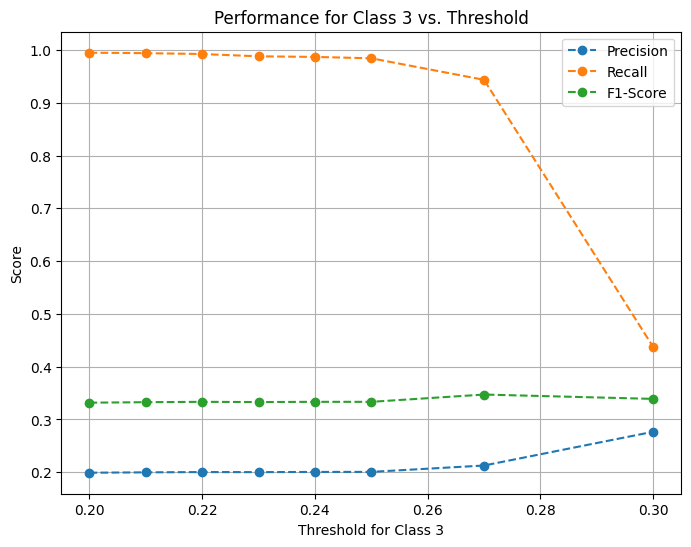

In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import joblib
import gc

# Disable debugger file validation (for Colab, if needed)
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"

# --- Assume combined_df is already loaded, preprocessed, and now includes engineered features ---
# For example, these engineered features were added before splitting:
# 'log_Fwd_Packet_Length_Max' and 'log_ratio_Fwd_Packet_Length_Max_to_act_data_pkt_fwd'

# 1. Prepare Features and Target
X = combined_df.drop(columns=[' Label', 'attack_type', 'severity'])
y = combined_df['severity']
print("Number of predictor features:", X.shape[1])  # Expected: 81 (if engineered features were added)

# Save original feature columns for inference later
original_feature_columns = X.columns.tolist()
joblib.dump(original_feature_columns, 'original_feature_columns.pkl')
print("Original feature columns saved.")

# 2. Downcast Numeric Data for Memory Efficiency
def downcast_df(df):
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = df[float_cols].astype('float32')
    int_cols = df.select_dtypes(include=['int64']).columns
    df[int_cols] = df[int_cols].astype('int32')
    return df

X = downcast_df(X)

# 3. Identify Categorical and Numerical Features for Preprocessing
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=[np.number]).columns

# 4. Build the Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 5. Compute Class Weights to Address Imbalance
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))
print("Class weights:", class_weights)

# 6. Create a Pipeline with LightGBM Classifier Using Class Weights
lgb_model = lgb.LGBMClassifier(
    n_estimators=50,    # Start with 50 for efficiency
    max_bin=255,
    random_state=42,
    n_jobs=-1,
    class_weight=class_weights
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb_model)
])

# 7. Split Data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Use a Representative Subset for Hyperparameter Tuning (e.g., 10% of training data)
sample_fraction = 0.1
X_train_subset = X_train.sample(frac=sample_fraction, random_state=42)
y_train_subset = y_train.loc[X_train_subset.index]
print("Training subset shape:", X_train_subset.shape)
del X_train, y_train
gc.collect()

# 9. Define the Hyperparameter Search Space (focusing on increasing model complexity)
param_distributions = {
    'classifier__n_estimators': [50, 75, 100],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__max_depth': [4, 5, 6, -1],  # Trying a deeper tree than 3
    'classifier__min_child_samples': [10, 20, 50],
    'classifier__num_leaves': [31, 63, 127]
}

# 10. Set Up RandomizedSearchCV on the Subset
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=10,               # Sample 10 combinations
    scoring='f1_weighted',   # Emphasize overall balance with a focus on minority classes
    cv=3,                    # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_subset, y_train_subset)
print("Best parameters found:")
print(random_search.best_params_)

# 11. Retrieve the Best Pipeline and Evaluate on the Full Validation Set
best_pipeline = random_search.best_estimator_
y_pred = best_pipeline.predict(X_val)
print("Classification Report on Validation Set:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix on Validation Set:")
print(confusion_matrix(y_val, y_pred))

# Save the tuned model and fitted numerical scaler
joblib.dump(best_pipeline, 'tuned_model_cicids_lightgbm.pkl')
fitted_scaler = best_pipeline.named_steps['preprocessor'].named_transformers_['num']
joblib.dump(fitted_scaler, 'tuned_scaler_cicids.pkl')
print("Tuned model and scaler saved as checkpoints.")

# 12. Re-run Threshold Calibration (if needed)
# This step assumes you have a custom prediction function; for example:
def custom_predict_with_thresholds(probabilities, thresholds):
    adjusted_preds = np.argmax(probabilities, axis=1)
    for class_label, threshold in thresholds.items():
        high_confidence = probabilities[:, class_label] >= threshold
        adjusted_preds[high_confidence] = class_label
    return adjusted_preds

# Obtain predicted probabilities on the validation set
y_prob_val = best_pipeline.predict_proba(X_val)

# Test a range of thresholds for class 3 and record performance
threshold_values = [0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.27, 0.3]
results = []

for threshold in threshold_values:
    print(f"\nTesting threshold = {threshold} for Class 3")
    custom_preds = custom_predict_with_thresholds(y_prob_val, {3: threshold})
    report = classification_report(y_val, custom_preds, output_dict=True)
    confusion = confusion_matrix(y_val, custom_preds)
    results.append((threshold, report["3"]["precision"], report["3"]["recall"], report["3"]["f1-score"]))
    print(f"Threshold {threshold} - Classification Report:")
    print(classification_report(y_val, custom_preds))
    print(f"Threshold {threshold} - Confusion Matrix:")
    print(confusion)

# Plot performance for class 3
results = np.array(results)
plt.figure(figsize=(8, 6))
plt.plot(results[:, 0], results[:, 1], label="Precision", marker='o', linestyle='dashed')
plt.plot(results[:, 0], results[:, 2], label="Recall", marker='o', linestyle='dashed')
plt.plot(results[:, 0], results[:, 3], label="F1-Score", marker='o', linestyle='dashed')
plt.xlabel("Threshold for Class 3")
plt.ylabel("Score")
plt.title("Performance for Class 3 vs. Threshold")
plt.legend()
plt.grid(True)
plt.show()


Low Thresholds (0.2–0.23):

* At 0.2, class 3 is predicted with very high recall (≈1.00) but extremely low precision (≈0.19), which leads to a very low overall accuracy (~31%) because many cases are overpredicted as critical.
* Increasing the threshold slightly (to 0.21–0.23) improves overall accuracy modestly (up to ~35–36%) but still results in very low precision for class 3. In these settings, many non-critical cases get misclassified as critical, leading to a flood of false alarms.

Moderate Thresholds (0.24–0.25):

* At 0.24–0.25, the overall accuracy remains low (~35%), and the performance for class 3 remains unsatisfactory, with precision around 0.20 and recall around 0.98. The confusion matrices show that the model is still misclassifying many cases.

Higher Thresholds (0.27–0.3):

* At 0.27, the overall accuracy improves to ~42%, and at 0.3, overall accuracy jumps to ~68%. However, for class 3, precision increases (0.28 at 0.3) but recall drops (0.27–0.44), resulting in an F1 score around 0.31–0.34.
* In other words, the model becomes much more conservative about predicting class 3, so you get fewer critical alerts, but the ones it does predict are more reliable.

Number of misclassified critical cases: 700
Number of correctly classified critical cases: 90569


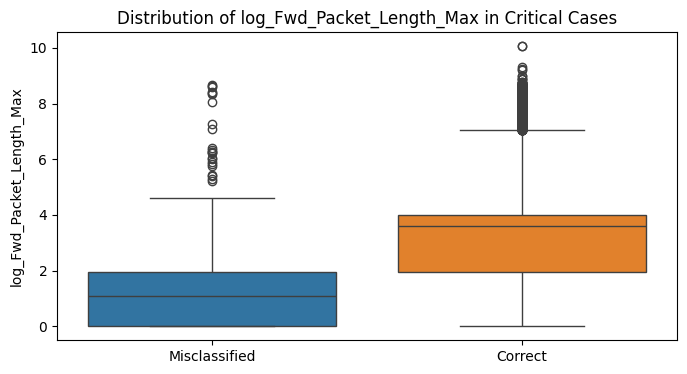

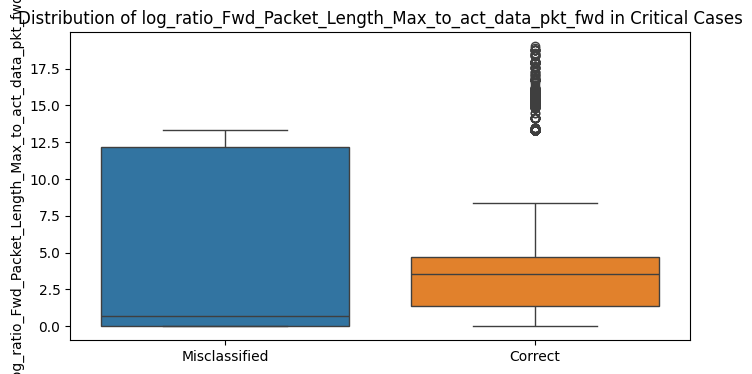

Descriptive statistics for engineered features in misclassified critical cases:
       log_Fwd_Packet_Length_Max  \
count                 700.000000   
mean                    1.003892   
std                     1.371023   
min                     0.000000   
25%                     0.000000   
50%                     1.098612   
75%                     1.945910   
max                     8.672657   

       log_ratio_Fwd_Packet_Length_Max_to_act_data_pkt_fwd  
count                                         700.000000    
mean                                            4.140605    
std                                             5.493597    
min                                             0.000000    
25%                                             0.000000    
50%                                             0.693146    
75%                                            12.206078    
max                                            13.304687    

Descriptive statistics for engineered feature

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assume that:
# - best_pipeline is your tuned model.
# - X_val and y_val are your validation data and labels.
# - y_prob_val has been computed as: y_prob_val = best_pipeline.predict_proba(X_val)
# - And that your engineered features (e.g., 'log_Fwd_Packet_Length_Max') are already present in X_val.

def custom_predict_with_thresholds(probabilities, thresholds):
    # Default prediction is argmax
    adjusted_preds = np.argmax(probabilities, axis=1)
    for class_label, threshold in thresholds.items():
        high_confidence = probabilities[:, class_label] >= threshold
        adjusted_preds[high_confidence] = class_label
    return adjusted_preds

# Set the chosen threshold for class 3 (e.g., 0.22)
chosen_threshold = 0.22
custom_preds = custom_predict_with_thresholds(y_prob_val, {3: chosen_threshold})

# Extract misclassified and correctly classified critical cases
misclassified_critical = X_val[(y_val == 3) & (custom_preds != 3)]
correctly_classified_critical = X_val[(y_val == 3) & (custom_preds == 3)]

print("Number of misclassified critical cases:", misclassified_critical.shape[0])
print("Number of correctly classified critical cases:", correctly_classified_critical.shape[0])

# Define key engineered features for analysis (adjust the feature names as needed)
key_features = ['log_Fwd_Packet_Length_Max', 'log_ratio_Fwd_Packet_Length_Max_to_act_data_pkt_fwd']

# Visualize the distributions using boxplots
for feature in key_features:
    plt.figure(figsize=(8, 4))
    # Combine the two groups into one DataFrame for easier plotting
    comp_df = pd.concat([
        misclassified_critical[feature].rename('Misclassified'),
        correctly_classified_critical[feature].rename('Correct')
    ], axis=1)
    sns.boxplot(data=comp_df)
    plt.title(f"Distribution of {feature} in Critical Cases")
    plt.ylabel(feature)
    plt.show()

# Print descriptive statistics for further insight
print("Descriptive statistics for engineered features in misclassified critical cases:")
print(misclassified_critical[key_features].describe())
print("\nDescriptive statistics for engineered features in correctly classified critical cases:")
print(correctly_classified_critical[key_features].describe())


Based on your results, we see clear differences between the misclassified and correctly classified critical cases:

**log_Fwd_Packet_Length_Max:**
* Misclassified Critical Cases: Median is about 1.10
* Correctly Classified Critical Cases: Median is about 3.61
* This suggests that correctly classified critical cases tend to have substantially higher maximum forward packet lengths, and the model is likely using this signal to correctly label critical events. Misclassified cases, on the other hand, often have very low or even zero values for this feature.

**log_ratio_Fwd_Packet_Length_Max_to_act_data_pkt_fwd:**
* Misclassified: Median is about 0.69
* Correctly Classified: Median is around 3.53
* Again, the ratio is much lower for the misclassified cases, indicating that in many critical cases that are missed, the forward packet length relative to the forward data packet count is very low.

Descriptive statistics for new binary flag (misclassified cases tend to have low values):
count    2.830743e+06
mean     1.589844e-01
std      3.656616e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: low_Fwd_Packet_Length_Max_flag, dtype: float64
Number of predictor features: 82
Original feature columns saved.
Class weights: {0: 0.38056562213810446, 1: 2.470391877598467, 2: 3.13489003078695, 3: 1.541906516358439}
Training subset shape: (226459, 82)
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15365
[LightGBM] [Info] Number of data points in the train set: 226459, number of used features: 74
[LightGBM] [Info] Start training from score -1.384360
[LightGBM] [Info] Start training from score -1.391803
[LightGBM] [Info] Start training from score -1.377794
[LightGBM] [Info] Start training from score -1.391287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77    372690
           1       0.96      0.55      0.70     57321
           2       0.93      0.71      0.80     44869
           3       0.28      0.44      0.34     91269

    accuracy                           0.68    566149
   macro avg       0.74      0.61      0.65    566149
weighted avg       0.74      0.68      0.70    566149

Confusion Matrix on Validation Set:
[[281024    831   1730  89105]
 [ 15924  31679    175   9543]
 [  7315     71  31767   5716]
 [ 50407    390    549  39923]]
Tuned model and scaler saved as checkpoints.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Testing threshold = 0.2 for Class 3
Threshold 0.2 - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.12      0.22    372690
           1       0.99      0.55      0.71     57321
           2       0.97      0.69      0.80     44869
           3       0.20      0.99      0.33     91269

    accuracy                           0.35    566149
   macro avg       0.79      0.59      0.52    566149
weighted avg       0.86      0.35      0.33    566149

Threshold 0.2 - Confusion Matrix:
[[ 46198    113    778 325601]
 [    27  31599     67  25628]
 [    24     44  30799  14002]
 [   124    210    141  90794]]

Testing threshold = 0.21 for Class 3
Threshold 0.21 - Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.13      0.23    372690
           1       0.99      0.55      0.71     57321
           2       0.97      0.69      0.80     44869
           3       0.20      0.99  

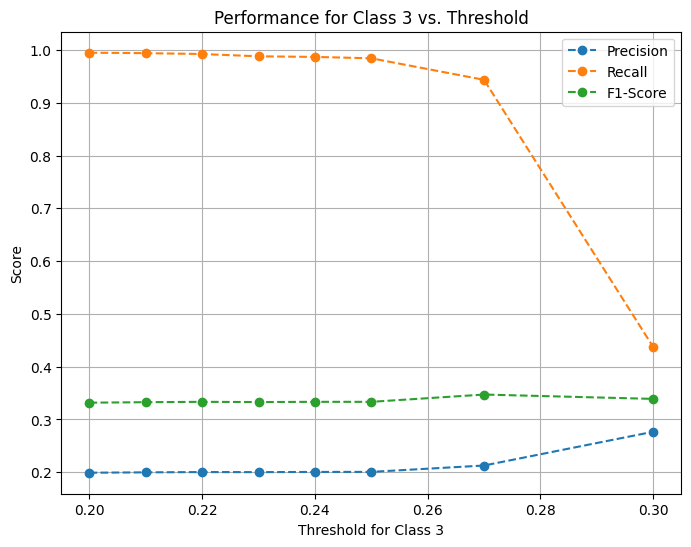

Number of misclassified critical cases: 700
Number of correctly classified critical cases: 90569


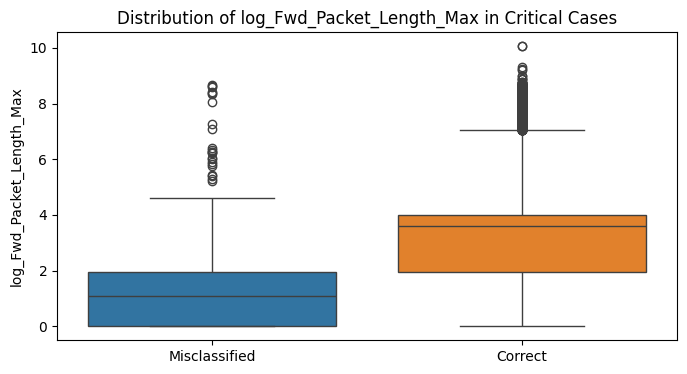

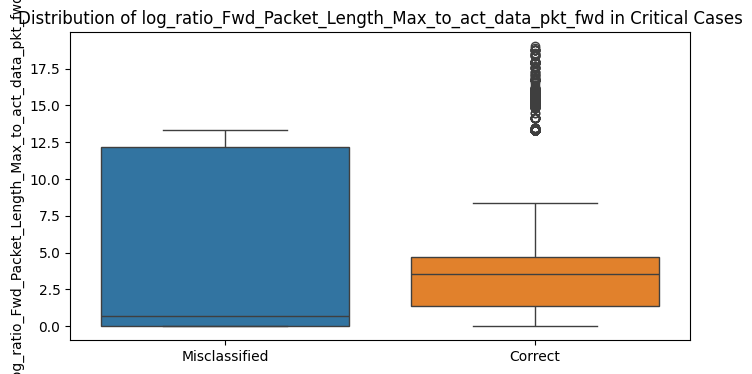

Descriptive statistics for engineered features in misclassified critical cases:
       log_Fwd_Packet_Length_Max  \
count                 700.000000   
mean                    1.003892   
std                     1.371023   
min                     0.000000   
25%                     0.000000   
50%                     1.098612   
75%                     1.945910   
max                     8.672657   

       log_ratio_Fwd_Packet_Length_Max_to_act_data_pkt_fwd  
count                                         700.000000    
mean                                            4.140605    
std                                             5.493597    
min                                             0.000000    
25%                                             0.000000    
50%                                             0.693146    
75%                                            12.206078    
max                                            13.304687    

Descriptive statistics for engineered feature

In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import joblib
import gc

# Disable debugger file validation (if using Colab)
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"

# ----- Assume that combined_df has already been created by loading and combining your CSVs -----
# For example, combined_df already has columns: ' Fwd Packet Length Max', ' act_data_pkt_fwd', etc.

# 1. Define severity mapping and apply it
severity_mapping = {
    "Benign": 0,
    "PortScan": 1,
    "Probe": 1,
    "DDos": 2,
    "Infilteration": 3,
    "WebAttacks": 3
}
combined_df['severity'] = combined_df['attack_type'].map(severity_mapping)

# 2. Data Cleaning: Replace infinite values and fill NaNs in numeric columns
combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)
numeric_cols = combined_df.select_dtypes(include=[np.number]).columns
combined_df[numeric_cols] = combined_df[numeric_cols].fillna(combined_df[numeric_cols].mean())

# 3. Feature Engineering (Perform these steps before splitting)
# a. Create a log-transformed feature for "Fwd Packet Length Max" using np.log1p (to handle zeros safely)
combined_df['log_Fwd_Packet_Length_Max'] = np.log1p(combined_df[' Fwd Packet Length Max'])

# b. Create an interaction feature: ratio of "Fwd Packet Length Max" to "act_data_pkt_fwd"
combined_df['Fwd_Packet_Length_Max_to_act_data_pkt_fwd'] = combined_df[' Fwd Packet Length Max'] / (combined_df[' act_data_pkt_fwd'] + 1e-5)
combined_df['log_ratio_Fwd_Packet_Length_Max_to_act_data_pkt_fwd'] = np.log1p(combined_df['Fwd_Packet_Length_Max_to_act_data_pkt_fwd'])

# c. **New Step:** Create a binary flag indicating low forward packet length max.
# Here, we flag if the log-transformed value is below 1 (you can adjust this threshold as needed)
combined_df['low_Fwd_Packet_Length_Max_flag'] = (combined_df['log_Fwd_Packet_Length_Max'] < 1).astype(int)

# ----- Optionally, visualize the new feature distributions (skip if not needed) -----
print("Descriptive statistics for new binary flag (misclassified cases tend to have low values):")
print(combined_df['low_Fwd_Packet_Length_Max_flag'].describe())

# 4. Prepare Features and Target for Modeling
# Drop non-predictor columns; adjust if your DataFrame contains additional columns (e.g., ' Label')
X = combined_df.drop(columns=[' Label', 'attack_type', 'severity'])
y = combined_df['severity']
print("Number of predictor features:", X.shape[1])

# Save original feature column names for later inference
original_feature_columns = X.columns.tolist()
joblib.dump(original_feature_columns, 'original_feature_columns.pkl')
print("Original feature columns saved.")

# 5. Downcast Numeric Data for Memory Efficiency
def downcast_df(df):
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = df[float_cols].astype('float32')
    int_cols = df.select_dtypes(include=['int64']).columns
    df[int_cols] = df[int_cols].astype('int32')
    return df

X = downcast_df(X)

# 6. Identify Categorical and Numerical Features for Preprocessing
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=[np.number]).columns

# 7. Build the Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 8. Compute Class Weights
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))
print("Class weights:", class_weights)

# 9. Create a Pipeline with LightGBM Classifier Using Class Weights
lgb_model = lgb.LGBMClassifier(
    n_estimators=50,
    max_bin=255,
    random_state=42,
    n_jobs=-1,
    class_weight=class_weights
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb_model)
])

# 10. Split Data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 11. Use a Subset for Hyperparameter Tuning (e.g., 10% of training data)
sample_fraction = 0.1
X_train_subset = X_train.sample(frac=sample_fraction, random_state=42)
y_train_subset = y_train.loc[X_train_subset.index]
print("Training subset shape:", X_train_subset.shape)
del X_train, y_train
gc.collect()

# 12. Define Hyperparameter Search Space (including increased max_depth)
param_distributions = {
    'classifier__n_estimators': [50, 75, 100],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__max_depth': [4, 5, 6, -1],  # Increased complexity
    'classifier__min_child_samples': [10, 20, 50],
    'classifier__num_leaves': [31, 63, 127]
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_subset, y_train_subset)
print("Best parameters found:")
print(random_search.best_params_)

# 13. Retrieve the Best Pipeline and Evaluate on Full Validation Set
best_pipeline = random_search.best_estimator_
y_pred = best_pipeline.predict(X_val)
print("Classification Report on Validation Set:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix on Validation Set:")
print(confusion_matrix(y_val, y_pred))

# Save the tuned model and fitted numerical scaler
joblib.dump(best_pipeline, 'tuned_model_cicids_lightgbm.pkl')
fitted_scaler = best_pipeline.named_steps['preprocessor'].named_transformers_['num']
joblib.dump(fitted_scaler, 'tuned_scaler_cicids.pkl')
print("Tuned model and scaler saved as checkpoints.")

# 14. Threshold Calibration and Sensitivity Analysis (Optional)
def custom_predict_with_thresholds(probabilities, thresholds):
    adjusted_preds = np.argmax(probabilities, axis=1)
    for class_label, threshold in thresholds.items():
        high_confidence = probabilities[:, class_label] >= threshold
        adjusted_preds[high_confidence] = class_label
    return adjusted_preds

# Get predicted probabilities on the validation set
y_prob_val = best_pipeline.predict_proba(X_val)

# Define thresholds for class 3 to test
threshold_values = [0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.27, 0.3]
results = []

for threshold in threshold_values:
    print(f"\nTesting threshold = {threshold} for Class 3")
    custom_preds = custom_predict_with_thresholds(y_prob_val, {3: threshold})
    report = classification_report(y_val, custom_preds, output_dict=True)
    confusion = confusion_matrix(y_val, custom_preds)
    results.append((threshold, report["3"]["precision"], report["3"]["recall"], report["3"]["f1-score"]))
    print(f"Threshold {threshold} - Classification Report:")
    print(classification_report(y_val, custom_preds))
    print(f"Threshold {threshold} - Confusion Matrix:")
    print(confusion)

results = np.array(results)
plt.figure(figsize=(8, 6))
plt.plot(results[:, 0], results[:, 1], label="Precision", marker='o', linestyle='dashed')
plt.plot(results[:, 0], results[:, 2], label="Recall", marker='o', linestyle='dashed')
plt.plot(results[:, 0], results[:, 3], label="F1-Score", marker='o', linestyle='dashed')
plt.xlabel("Threshold for Class 3")
plt.ylabel("Score")
plt.title("Performance for Class 3 vs. Threshold")
plt.legend()
plt.grid(True)
plt.show()

# 15. Analyze Misclassified Critical Cases for Further Feature Engineering
chosen_threshold = 0.22
custom_preds_final = custom_predict_with_thresholds(y_prob_val, {3: chosen_threshold})
misclassified_critical = X_val[(y_val == 3) & (custom_preds_final != 3)]
correctly_classified_critical = X_val[(y_val == 3) & (custom_preds_final == 3)]
print("Number of misclassified critical cases:", misclassified_critical.shape[0])
print("Number of correctly classified critical cases:", correctly_classified_critical.shape[0])

# Compare engineered feature distributions between the two groups
new_features = ['log_Fwd_Packet_Length_Max', 'log_ratio_Fwd_Packet_Length_Max_to_act_data_pkt_fwd']
for feature in new_features:
    plt.figure(figsize=(8, 4))
    comp_df = pd.concat([
        misclassified_critical[feature].rename('Misclassified'),
        correctly_classified_critical[feature].rename('Correct')
    ], axis=1)
    sns.boxplot(data=comp_df)
    plt.title(f"Distribution of {feature} in Critical Cases")
    plt.ylabel(feature)
    plt.show()

print("Descriptive statistics for engineered features in misclassified critical cases:")
print(misclassified_critical[new_features].describe())
print("\nDescriptive statistics for engineered features in correctly classified critical cases:")
print(correctly_classified_critical[new_features].describe())


In [2]:
import os
import pandas as pd

# Define file paths (adjust these paths to your environment)
file_paths = [
    r"/content/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
    r"/content/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    r"/content/Friday-WorkingHours-Morning.pcap_ISCX.csv",
    r"/content/Monday-WorkingHours.pcap_ISCX.csv",
    r"/content/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
    r"/content/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
    r"/content/Tuesday-WorkingHours.pcap_ISCX.csv",
    r"/content/Wednesday-workingHours.pcap_ISCX.csv"
]

# Define attack type mapping based on file names
attack_type_mapping = {
    "DDos": "DDos",
    "PortScan": "PortScan",
    "Infilteration": "Infilteration",
    "WebAttacks": "WebAttacks",
    "Morning": "Benign",
    "Afternoon": "Benign",
    "Monday": "Benign",
    "Tuesday": "Benign",
    "Wednesday": "Benign",
    "Thursday": "Benign",
    "Friday": "Benign"
}

# Load and combine the data into a single DataFrame
data_frames = []
for file_path in file_paths:
    df = pd.read_csv(file_path)
    for key, value in attack_type_mapping.items():
        if key in file_path:
            df['attack_type'] = value
            break
    data_frames.append(df)

combined_df = pd.concat(data_frames, ignore_index=True)
print("Data loaded. combined_df has shape:", combined_df.shape)

Data loaded. combined_df has shape: (2830743, 80)


In [3]:

severity_mapping = {
    "Benign": 0,
    "PortScan": 1,
    "Probe": 1,
    "DDos": 2,
    "Infilteration": 3,
    "WebAttacks": 3
}
combined_df['severity'] = combined_df['attack_type'].map(severity_mapping)

# 1. Data Cleaning: Replace infinities and fill missing values for numeric columns
combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)
numeric_cols = combined_df.select_dtypes(include=[np.number]).columns
combined_df[numeric_cols] = combined_df[numeric_cols].fillna(combined_df[numeric_cols].mean())

In [4]:
# 2. Enhanced Feature Engineering:
# a. Log-transform "Fwd Packet Length Max" (use np.log1p to handle zeros)
combined_df['log_Fwd_Packet_Length_Max'] = np.log1p(combined_df[' Fwd Packet Length Max'])

# b. Create an interaction feature: ratio of "Fwd Packet Length Max" to "act_data_pkt_fwd"
combined_df['Fwd_Packet_Length_Max_to_act_data_pkt_fwd'] = combined_df[' Fwd Packet Length Max'] / (combined_df[' act_data_pkt_fwd'] + 1e-5)
combined_df['log_ratio_Fwd_Packet_Length_Max_to_act_data_pkt_fwd'] = np.log1p(combined_df['Fwd_Packet_Length_Max_to_act_data_pkt_fwd'])

# c. Create a binary flag for low values of log_Fwd_Packet_Length_Max (threshold < 1)
combined_df['low_Fwd_Packet_Length_Max_flag'] = (combined_df['log_Fwd_Packet_Length_Max'] < 1).astype(int)

# Optionally, visualize these engineered features:
print("Descriptive statistics for low_Fwd_Packet_Length_Max_flag:")
print(combined_df['low_Fwd_Packet_Length_Max_flag'].describe())
# (You can plot distributions using seaborn if needed)

Descriptive statistics for low_Fwd_Packet_Length_Max_flag:
count    2.830743e+06
mean     1.589844e-01
std      3.656616e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: low_Fwd_Packet_Length_Max_flag, dtype: float64


In [5]:
# 3. Prepare Features and Target
# Drop non-predictor columns; adjust if needed
X = combined_df.drop(columns=[' Label', 'attack_type', 'severity'])
y = combined_df['severity']
print("Number of predictor features:", X.shape[1])  # Expecting an increase (e.g., from 81 to 82)

# Save the original feature column names for later inference
original_feature_columns = X.columns.tolist()
joblib.dump(original_feature_columns, 'original_feature_columns.pkl')
print("Original feature columns saved.")

Number of predictor features: 82
Original feature columns saved.


In [6]:
# 4. Downcast Numeric Data for Memory Efficiency
def downcast_df(df):
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = df[float_cols].astype('float32')
    int_cols = df.select_dtypes(include=['int64']).columns
    df[int_cols] = df[int_cols].astype('int32')
    return df

X = downcast_df(X)

In [7]:
# 5. Identify Categorical and Numerical Features for Preprocessing
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=[np.number]).columns

In [8]:
# 6. Build Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [9]:
# 7. Compute Class Weights
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))
print("Class weights:", class_weights)

Class weights: {0: 0.38056562213810446, 1: 2.470391877598467, 2: 3.13489003078695, 3: 1.541906516358439}


In [10]:
# 8. Create a Pipeline with LightGBM Classifier Using Class Weights
lgb_model = lgb.LGBMClassifier(
    n_estimators=50,
    max_bin=255,
    random_state=42,
    n_jobs=-1,
    class_weight=class_weights
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb_model)
])

In [11]:
# 9. Split Data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# 10. Use a Representative Subset for Hyperparameter Tuning (e.g., 10% of training data)
sample_fraction = 0.1
X_train_subset = X_train.sample(frac=sample_fraction, random_state=42)
y_train_subset = y_train.loc[X_train_subset.index]
print("Training subset shape:", X_train_subset.shape)
del X_train, y_train
gc.collect()

Training subset shape: (226459, 82)


0

In [13]:
# 11. Define Hyperparameter Search Space
param_distributions = {
    'classifier__n_estimators': [50, 75, 100],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__max_depth': [4, 5, 6, -1],
    'classifier__min_child_samples': [10, 20, 50],
    'classifier__num_leaves': [31, 63, 127]
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_subset, y_train_subset)
print("Best parameters found:")
print(random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.196892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15365
[LightGBM] [Info] Number of data points in the train set: 226459, number of used features: 74
[LightGBM] [Info] Start training from score -1.384360
[LightGBM] [Info] Start training from score -1.391803
[LightGBM] [Info] Start training from score -1.377794
[LightGBM] [Info] Start training from score -1.391287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

In [14]:
# 12. Retrieve the Best Pipeline and Evaluate on the Full Validation Set
best_pipeline = random_search.best_estimator_
y_pred = best_pipeline.predict(X_val)
print("Classification Report on Validation Set:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix on Validation Set:")
print(confusion_matrix(y_val, y_pred))

# Save the tuned model and fitted numerical scaler
joblib.dump(best_pipeline, 'tuned_model_cicids_lightgbm.pkl')
fitted_scaler = best_pipeline.named_steps['preprocessor'].named_transformers_['num']
joblib.dump(fitted_scaler, 'tuned_scaler_cicids.pkl')
print("Tuned model and scaler saved as checkpoints.")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77    372690
           1       0.96      0.55      0.70     57321
           2       0.93      0.71      0.80     44869
           3       0.28      0.44      0.34     91269

    accuracy                           0.68    566149
   macro avg       0.74      0.61      0.65    566149
weighted avg       0.74      0.68      0.70    566149

Confusion Matrix on Validation Set:
[[281024    831   1730  89105]
 [ 15924  31679    175   9543]
 [  7315     71  31767   5716]
 [ 50407    390    549  39923]]
Tuned model and scaler saved as checkpoints.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Testing threshold = 0.2 for Class 3
Threshold 0.2 - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.12      0.22    372690
           1       0.99      0.55      0.71     57321
           2       0.97      0.69      0.80     44869
           3       0.20      0.99      0.33     91269

    accuracy                           0.35    566149
   macro avg       0.79      0.59      0.52    566149
weighted avg       0.86      0.35      0.33    566149

Threshold 0.2 - Confusion Matrix:
[[ 46198    113    778 325601]
 [    27  31599     67  25628]
 [    24     44  30799  14002]
 [   124    210    141  90794]]

Testing threshold = 0.21 for Class 3
Threshold 0.21 - Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.13      0.23    372690
           1       0.99      0.55      0.71     57321
           2       0.97      0.69      0.80     44869
           3       0.20      0.99  

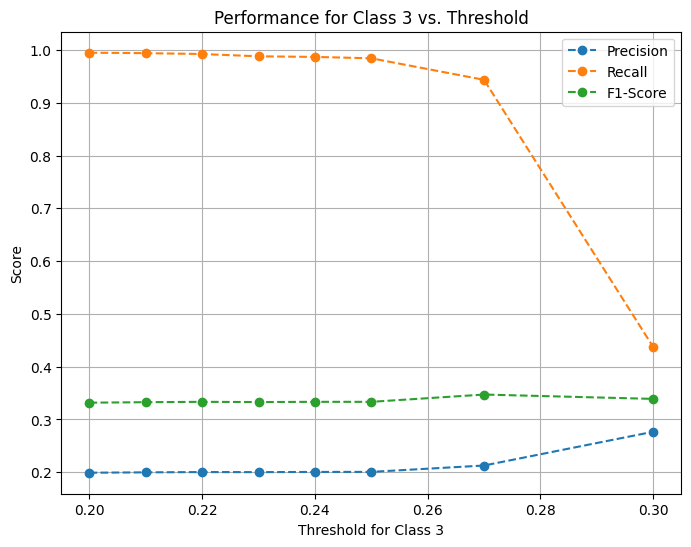

In [15]:
# 13. Threshold Calibration and Sensitivity Analysis
def custom_predict_with_thresholds(probabilities, thresholds):
    adjusted_preds = np.argmax(probabilities, axis=1)
    for class_label, threshold in thresholds.items():
        high_confidence = probabilities[:, class_label] >= threshold
        adjusted_preds[high_confidence] = class_label
    return adjusted_preds

# Obtain predicted probabilities on the validation set
y_prob_val = best_pipeline.predict_proba(X_val)

# Define thresholds for class 3 to test
threshold_values = [0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.27, 0.3]
results = []

for threshold in threshold_values:
    print(f"\nTesting threshold = {threshold} for Class 3")
    custom_preds = custom_predict_with_thresholds(y_prob_val, {3: threshold})
    report = classification_report(y_val, custom_preds, output_dict=True)
    confusion = confusion_matrix(y_val, custom_preds)
    results.append((threshold, report["3"]["precision"], report["3"]["recall"], report["3"]["f1-score"]))
    print(f"Threshold {threshold} - Classification Report:")
    print(classification_report(y_val, custom_preds))
    print(f"Threshold {threshold} - Confusion Matrix:")
    print(confusion)

results = np.array(results)
plt.figure(figsize=(8, 6))
plt.plot(results[:, 0], results[:, 1], label="Precision", marker='o', linestyle='dashed')
plt.plot(results[:, 0], results[:, 2], label="Recall", marker='o', linestyle='dashed')
plt.plot(results[:, 0], results[:, 3], label="F1-Score", marker='o', linestyle='dashed')
plt.xlabel("Threshold for Class 3")
plt.ylabel("Score")
plt.title("Performance for Class 3 vs. Threshold")
plt.legend()
plt.grid(True)
plt.show()

Number of misclassified critical cases: 700
Number of correctly classified critical cases: 90569


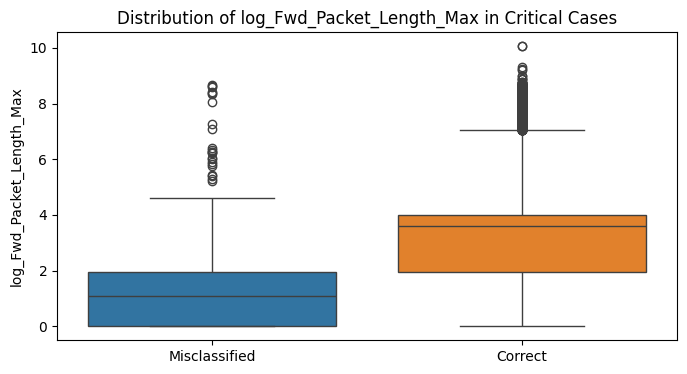

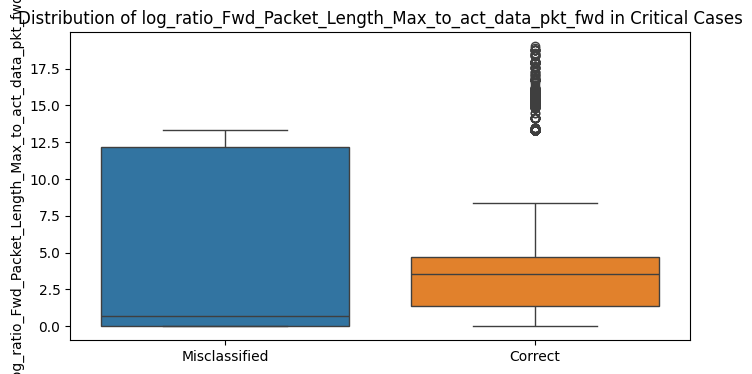

Descriptive statistics for engineered features in misclassified critical cases:
       log_Fwd_Packet_Length_Max  \
count                 700.000000   
mean                    1.003892   
std                     1.371023   
min                     0.000000   
25%                     0.000000   
50%                     1.098612   
75%                     1.945910   
max                     8.672657   

       log_ratio_Fwd_Packet_Length_Max_to_act_data_pkt_fwd  
count                                         700.000000    
mean                                            4.140605    
std                                             5.493597    
min                                             0.000000    
25%                                             0.000000    
50%                                             0.693146    
75%                                            12.206078    
max                                            13.304687    

Descriptive statistics for engineered feature

In [16]:
# 14. Analyze Misclassified Critical Cases for Further Feature Engineering
chosen_threshold = 0.22
custom_preds_final = custom_predict_with_thresholds(y_prob_val, {3: chosen_threshold})
misclassified_critical = X_val[(y_val == 3) & (custom_preds_final != 3)]
correctly_classified_critical = X_val[(y_val == 3) & (custom_preds_final == 3)]
print("Number of misclassified critical cases:", misclassified_critical.shape[0])
print("Number of correctly classified critical cases:", correctly_classified_critical.shape[0])

# Compare engineered feature distributions between the two groups
new_features = ['log_Fwd_Packet_Length_Max', 'log_ratio_Fwd_Packet_Length_Max_to_act_data_pkt_fwd']
for feature in new_features:
    plt.figure(figsize=(8, 4))
    comp_df = pd.concat([
        misclassified_critical[feature].rename('Misclassified'),
        correctly_classified_critical[feature].rename('Correct')
    ], axis=1)
    sns.boxplot(data=comp_df)
    plt.title(f"Distribution of {feature} in Critical Cases")
    plt.ylabel(feature)
    plt.show()

print("Descriptive statistics for engineered features in misclassified critical cases:")
print(misclassified_critical[new_features].describe())
print("\nDescriptive statistics for engineered features in correctly classified critical cases:")
print(correctly_classified_critical[new_features].describe())

In [17]:
import joblib
original_feature_columns = joblib.load('original_feature_columns.pkl')
print("Expected number of features:", len(original_feature_columns))
print("Feature columns:", original_feature_columns)


Expected number of features: 82
Feature columns: [' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', 